# DnD Character Class Classification

## 1. Wstęp

In [1]:
# importy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [2]:
# prezentacja bazy danych
# Zbiór danych zawiera 10000 wierszy wygenerowanych statystyk dla dziewięciu różnych klas postaci z gry Dungeons & Dragons.
df = pd.read_csv('data/stats.csv') 
print(df.shape)
df.describe()
# nie ma żadnych brakujących wartości, baza jest kompletna

(10000, 10)


height        weight         speed     strength     dexterity  \
count  10000.000000  10000.000000  10000.000000  10000.00000  10000.000000   
mean      59.597500    146.863500     28.324500     12.85130     12.838400   
std       13.283107     68.304729      2.360245      2.96494      2.945531   
min       33.000000     39.000000     25.000000      3.00000      3.000000   
25%       52.000000    120.000000     25.000000     11.00000     11.000000   
50%       64.000000    154.000000     30.000000     13.00000     13.000000   
75%       69.000000    188.000000     30.000000     15.00000     15.000000   
max       82.000000    367.000000     30.000000     20.00000     20.000000   

       constitution  intelligence       wisdom      charisma  
count  10000.000000  10000.000000  10000.00000  10000.000000  
mean      12.752800     12.752900     12.41650     12.870100  
std        2.924953      2.947119      2.89283      2.974746  
min        3.000000      3.000000      3.00000      3.000000  
25%       11.000000     11.000000     10.00000     11.000000  
50%       13.000000     13.000000     13.00000     13.000000  
75%       15.000000     15.000000     15.00000     15.000000  
max       20.000000     20.000000     19.00000     20.000000

In [3]:
df.head()

race  height  weight  speed  strength  dexterity  constitution  \
0  dragonborn      79     279     30        14         15            12   
1  dragonborn      79     331     30        11         11            11   
2  dragonborn      71     230     30        14         16            11   
3  dragonborn      75     265     30         8         19             7   
4  dragonborn      72     229     30         8         17            14   

   intelligence  wisdom  charisma  
0             7      13        16  
1            13      13        17  
2            13      10        18  
3            10      13        16  
4            14      10         9

In [4]:
print(df['race'].unique()) # mamy 9 klas postaci do klasyfikacji

['dragonborn' 'dwarf' 'elf' 'gnome' 'half.elf' 'half.orc' 'halfling'
 'human' 'tiefling']


## 2. Preprocessing

1) PCA, normalizacja, itp.
2) Przygować dwie wersje bazy danych: jedną mniej przetworzoną, a drugą bardziej.

In [5]:
# podział bazy danych na zbiór testowy i treningowy
(train_set, test_set) = train_test_split(df.values, train_size=0.7, random_state=274260)
train_inputs = train_set[:, 1:10]
train_classes = train_set[:, 0]
test_inputs = test_set[:, 1:10]
test_classes = test_set[:, 0]

In [6]:
# skalowanie
scaler = StandardScaler()
y = df.race
X = df.drop(df.columns[0], axis = 1)
scaler.fit(X)
X_scaled = scaler.fit_transform(X)

In [7]:
# pca
PCA = PCA()
PCA.fit(X_scaled)
evr = pd.DataFrame(PCA.components_, columns=X.columns)
evr['explained_var_ratio'] = PCA.explained_variance_ratio_
evr

height    weight     speed  strength  dexterity  constitution  \
0 -0.585519 -0.541646 -0.537353 -0.172207  -0.151413     -0.007221   
1 -0.044534  0.069725 -0.126655  0.335846   0.272919      0.506953   
2 -0.036694 -0.030802 -0.020967  0.076955   0.226286     -0.554035   
3  0.045386  0.049613  0.024535 -0.480906  -0.422670      0.259103   
4 -0.028740 -0.051763  0.021408  0.128041  -0.042573     -0.572187   
5  0.086219  0.056167  0.092448  0.327585  -0.811541     -0.096992   
6  0.132756  0.110519  0.121112 -0.704083   0.097568     -0.138564   
7  0.008029  0.700827 -0.696986 -0.028636  -0.052152     -0.113323   
8 -0.791094  0.434904  0.429774 -0.010003  -0.009099      0.003183   

   intelligence    wisdom  charisma  explained_var_ratio  
0      0.075824 -0.005088 -0.128961             0.309335  
1     -0.405593 -0.125840 -0.593711             0.118774  
2     -0.184422 -0.773400 -0.032003             0.113938  
3     -0.643119 -0.218406  0.237737             0.110581  
4     -0.558123  0.553568 -0.180255             0.106411  
5      0.181930 -0.171943 -0.377999             0.103777  
6      0.188291  0.024875 -0.628465             0.099615  
7      0.044350  0.040844  0.054499             0.034651  
8      0.010523 -0.000069  0.004435             0.002919

In [8]:
# ponieważ pca sortuje kolumny,
# wybieramy tyle pierwszych komponentów, żeby ich skumulowana wartość wariancji
# wyjaśniała ponad 95% całkowitej wariancji
X2 = PCA.transform(X_scaled)
df2 = pd.DataFrame(X2[:,:7], columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7'])
df2['race'] = df.race
df2.head()

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6      PCA7  \
0 -2.745379  0.321539  0.380747  1.078039  1.050243 -0.931032 -0.695640   
1 -2.664379 -1.534557 -0.224695  0.858390 -0.062209  0.158868  0.187900   
2 -1.980132 -0.876792  1.096292 -0.140009 -0.545767 -0.971047 -0.839378   
3 -2.225617 -1.267906  1.309073  0.355794  1.162564 -2.382566  1.227678   
4 -1.310679  0.710527  0.481041  0.020644 -1.051653 -0.797927  2.450276   

         race  
0  dragonborn  
1  dragonborn  
2  dragonborn  
3  dragonborn  
4  dragonborn

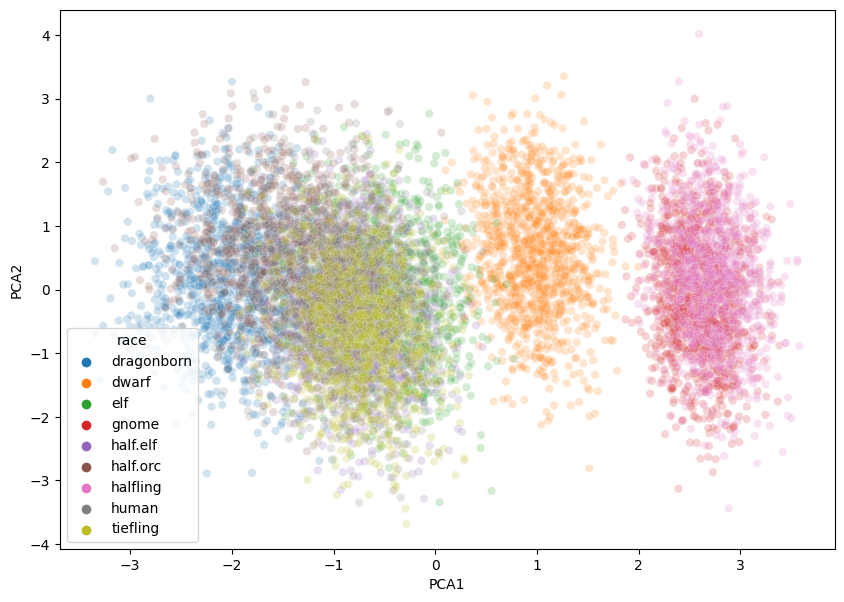

In [9]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df2, x='PCA1', y='PCA2', hue='race', alpha=0.2)
plt.show()
# z wykresu możemy wywnioskować, że klasy postaci, których klastry na siebie nachodzą
# mogą sie mylić podczas klasyfikacji, natomiast klasa dwarf będzie raczej łatwa do rozpoznania

In [10]:
# przetworzone dane
(train_set2, test_set2) = train_test_split(df2.values, train_size=0.7, random_state=274260)
train_inputs2 = train_set2[:, :7]
train_classes2 = train_set2[:, 7]
test_inputs2 = test_set2[:, :7]
test_classes2 = test_set2[:, 7]

## 3. Klasyfikacja

1) Podzielić bazę danych na zbiór testowy i treningowy (i ewentualnie walidacyjny).
2) Wytrenować klasyfikatory na zbiorze treningowym:
    - drzewo decyzyjne (w wersji mniejsze z przyciętymi gałęziami i większej),
    - naiwny Bayes,
    - k-najbliższych sąsiadów (dla paru różnych k),
    - sieć neuronowa (dla paru topologii i być może dla paru konfiguracji uczenia).
3) Przetestować klasyfikatory na zbiorze testowym.
4) Podać dokładność (accuracy) oraz macierz błędów (najlepiej w formie graficznej), a w przypadku sieci neuronowych również krzywą uczenia się (learning curve) uwzględniająca zbiór treningowy i walidacyjny.

In [11]:
# w poniższych listach zapiszemy dokładność kolejnych klasyfikatorów dla pierwszego i drugiego zbioru danych,
# które porównamy na końcu w tabeli
lista1 = []
lista2 = []

### Drzewo decyzyjne bez przyciętych gałęzi

In [12]:
# sprawdzimy, które kryterium podziału jest bardziej efektywne
DDg = tree.DecisionTreeClassifier(criterion='gini')
DDg = DDg.fit(train_inputs, train_classes)
print('Dokładność dla criterion = gini: {:.2f}%'.format(accuracy_score(test_classes, DDg.predict(test_inputs)) * 100))
DDe = tree.DecisionTreeClassifier(criterion='entropy')
DDe = DDe.fit(train_inputs, train_classes)
print('Dokładność dla criterion = entropy: {:.2f}%'.format(accuracy_score(test_classes, DDe.predict(test_inputs)) * 100))
# wybieramy entropię

Dokładność dla criterion = gini: 68.03%
Dokładność dla criterion = entropy: 68.40%


[Text(0.31424337834199345, 0.9814814814814815, 'x[2] <= 27.5\nentropy = 3.169\nsamples = 7000\nvalue = [787, 740, 765, 799, 767, 753, 818, 803, 768]'),
 Text(0.0037682524729156855, 0.9444444444444444, 'x[1] <= 90.5\nentropy = 1.584\nsamples = 2357\nvalue = [0, 740, 0, 799, 0, 0, 818, 0, 0]'),
 Text(0.0031402103940964044, 0.9074074074074074, 'x[0] <= 38.5\nentropy = 1.0\nsamples = 1617\nvalue = [0, 0, 0, 799, 0, 0, 818, 0, 0]'),
 Text(0.0018841262364578427, 0.8703703703703703, 'x[1] <= 40.5\nentropy = 0.601\nsamples = 900\nvalue = [0, 0, 0, 132, 0, 0, 768, 0, 0]'),
 Text(0.0012560841576385617, 0.8333333333333334, 'x[0] <= 35.5\nentropy = 0.999\nsamples = 275\nvalue = [0, 0, 0, 132, 0, 0, 143, 0, 0]'),
 Text(0.0006280420788192808, 0.7962962962962963, 'entropy = 0.0\nsamples = 143\nvalue = [0, 0, 0, 0, 0, 0, 143, 0, 0]'),
 Text(0.0018841262364578427, 0.7962962962962963, 'entropy = 0.0\nsamples = 132\nvalue = [0, 0, 0, 132, 0, 0, 0, 0, 0]'),
 Text(0.0025121683152771234, 0.8333333333333334,

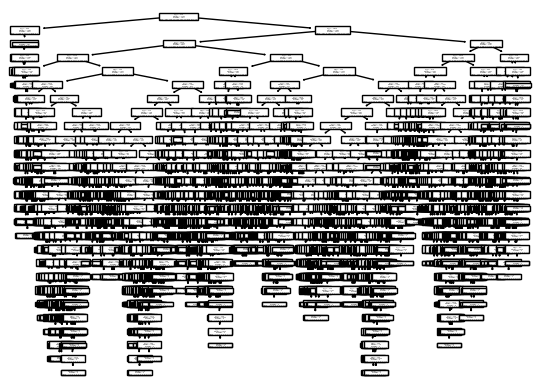

In [13]:
# dane bez skalowania
DD = tree.DecisionTreeClassifier(criterion='entropy')
DD = DD.fit(train_inputs, train_classes)
tree.plot_tree(DD)
# wykres sieci jest nieczytelny
# zbyt duża głębokość drzewa może prowadzić do przeuczenia

In [14]:
acc = accuracy_score(test_classes, DD.predict(test_inputs))
print('Dokładność: {:.2f}%'.format(acc * 100))
lista1.append(round(acc, 2))
print(confusion_matrix(test_classes, DD.predict(test_inputs)))

Dokładność: 68.57%
[[326   0   4   0   3  18   0   5   1]
 [  0 355   0   0   0   0   0   0   0]
 [  4   0 164   0  65  15   0  48  51]
 [  0   0   0 322   0   0   0   0   0]
 [  4   0  58   0 105   7   0  76  69]
 [ 18   0   7   0  12 234   0  29  14]
 [  0   0   0   0   0   0 317   0   0]
 [ 11   0  40   0  67  20   0 121  58]
 [  4   0  64   0 106  13   0  52 113]]


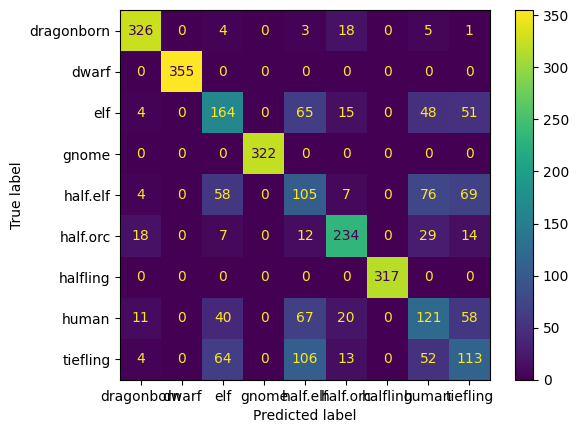

In [15]:
cm = confusion_matrix(test_classes, DD.predict(test_inputs), labels = DD.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = DD.classes_)
cm_display.plot()
plt.show()
# dwarf, halfling i gnome przewiduje dobrze

[Text(0.6314520875201516, 0.98, 'x[0] <= 0.291\nentropy = 3.169\nsamples = 7000\nvalue = [787, 740, 765, 799, 767, 753, 818, 803, 768]'),
 Text(0.35730830112967554, 0.94, 'x[0] <= -1.299\nentropy = 2.598\nsamples = 4623\nvalue = [787, 8, 741, 0, 765, 753, 0, 803, 766]'),
 Text(0.10841203180748084, 0.9, 'x[0] <= -1.718\nentropy = 1.86\nsamples = 1506\nvalue = [736, 0, 36, 0, 71, 463, 0, 149, 51]'),
 Text(0.03348038032988244, 0.86, 'x[0] <= -2.024\nentropy = 1.238\nsamples = 851\nvalue = [562, 0, 4, 0, 7, 239, 0, 32, 7]'),
 Text(0.011771070948119553, 0.82, 'x[1] <= -0.321\nentropy = 0.917\nsamples = 489\nvalue = [364, 0, 0, 0, 1, 117, 0, 7, 0]'),
 Text(0.004445224308358192, 0.78, 'x[3] <= -0.816\nentropy = 0.625\nsamples = 129\nvalue = [115, 0, 0, 0, 1, 9, 0, 4, 0]'),
 Text(0.0023395917412411533, 0.74, 'x[3] <= -1.652\nentropy = 1.017\nsamples = 34\nvalue = [27, 0, 0, 0, 1, 2, 0, 4, 0]'),
 Text(0.0014037550447446921, 0.7, 'x[3] <= -1.725\nentropy = 1.299\nsamples = 8\nvalue = [5, 0, 0, 0

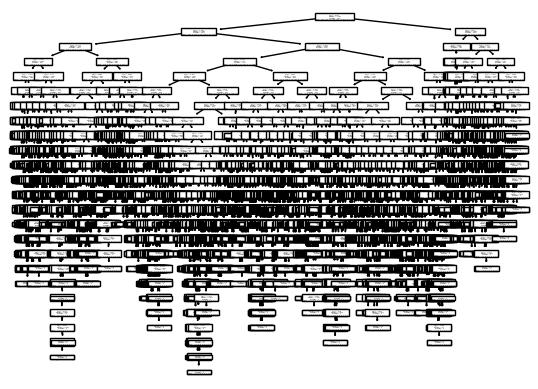

In [16]:
# dane znormalizowane
DD2 = tree.DecisionTreeClassifier(criterion='entropy')
DD2 = DD2.fit(train_inputs2, train_classes2)
tree.plot_tree(DD2)

In [17]:
acc2 = accuracy_score(test_classes2, DD2.predict(test_inputs2))
print('Dokładność: {:.2f}%'.format(acc2 * 100))
lista2.append(round(acc2, 2))
print(confusion_matrix(test_classes2, DD2.predict(test_inputs2)))

Dokładność: 48.83%
[[216   0   5   0   9  89   0  27  11]
 [  0 345   7   1   1   0   0   0   1]
 [  4   2 114   0  73  33   0  49  72]
 [  0   2   0 230   0   0  90   0   0]
 [  5   0  65   0  72  31   0  72  74]
 [100   0  25   0  31  82   0  53  23]
 [  0   1   0 105   0   0 211   0   0]
 [ 24   0  47   0  60  46   0  81  59]
 [ 12   0  67   0  67  35   0  57 114]]


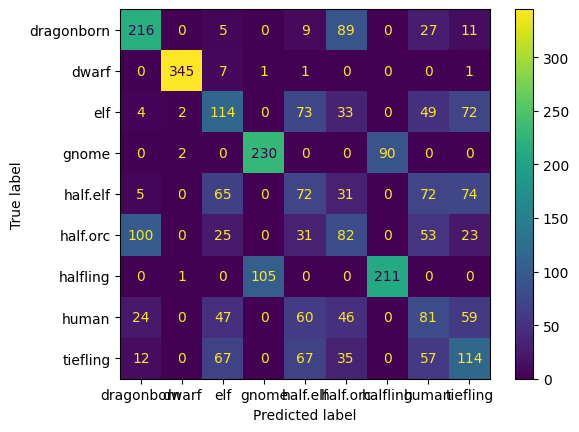

In [18]:
cm2 = confusion_matrix(test_classes2, DD2.predict(test_inputs2), labels = DD2.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = DD2.classes_)
cm_display.plot()
plt.show()

### Drzewo decyzyjne z przyciętymi gałęziami

In [19]:
# na jakiej głębokości należy przyciąć gałęzie drzewa, żeby zmaksymalizować dokładność?
for i in range(10, 33):
    DD = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    DD = DD.fit(train_inputs, train_classes)
    print("Dokładność dla depth = ", i ," wynosi :", round(accuracy_score(test_classes, DD.predict(test_inputs)), 4))
# weźmiemy max_depth = 26

Dokładność dla depth =  10  wynosi : 0.658
Dokładność dla depth =  11  wynosi : 0.6673
Dokładność dla depth =  12  wynosi : 0.665
Dokładność dla depth =  13  wynosi : 0.6703
Dokładność dla depth =  14  wynosi : 0.676
Dokładność dla depth =  15  wynosi : 0.6797
Dokładność dla depth =  16  wynosi : 0.6777
Dokładność dla depth =  17  wynosi : 0.683
Dokładność dla depth =  18  wynosi : 0.6827
Dokładność dla depth =  19  wynosi : 0.6783
Dokładność dla depth =  20  wynosi : 0.6793
Dokładność dla depth =  21  wynosi : 0.6837
Dokładność dla depth =  22  wynosi : 0.684
Dokładność dla depth =  23  wynosi : 0.6833
Dokładność dla depth =  24  wynosi : 0.681
Dokładność dla depth =  25  wynosi : 0.686
Dokładność dla depth =  26  wynosi : 0.6873
Dokładność dla depth =  27  wynosi : 0.686
Dokładność dla depth =  28  wynosi : 0.688
Dokładność dla depth =  29  wynosi : 0.685
Dokładność dla depth =  30  wynosi : 0.6803
Dokładność dla depth =  31  wynosi : 0.6893
Dokładność dla depth =  32  wynosi : 0.682

[Text(0.31312336016643705, 0.9814814814814815, 'x[2] <= 27.5\nentropy = 3.169\nsamples = 7000\nvalue = [787, 740, 765, 799, 767, 753, 818, 803, 768]'),
 Text(0.0037422523681440766, 0.9444444444444444, 'x[1] <= 90.5\nentropy = 1.584\nsamples = 2357\nvalue = [0, 740, 0, 799, 0, 0, 818, 0, 0]'),
 Text(0.003118543640120064, 0.9074074074074074, 'x[0] <= 38.5\nentropy = 1.0\nsamples = 1617\nvalue = [0, 0, 0, 799, 0, 0, 818, 0, 0]'),
 Text(0.0018711261840720383, 0.8703703703703703, 'x[1] <= 40.5\nentropy = 0.601\nsamples = 900\nvalue = [0, 0, 0, 132, 0, 0, 768, 0, 0]'),
 Text(0.0012474174560480255, 0.8333333333333334, 'x[0] <= 35.5\nentropy = 0.999\nsamples = 275\nvalue = [0, 0, 0, 132, 0, 0, 143, 0, 0]'),
 Text(0.0006237087280240128, 0.7962962962962963, 'entropy = 0.0\nsamples = 143\nvalue = [0, 0, 0, 0, 0, 0, 143, 0, 0]'),
 Text(0.0018711261840720383, 0.7962962962962963, 'entropy = 0.0\nsamples = 132\nvalue = [0, 0, 0, 132, 0, 0, 0, 0, 0]'),
 Text(0.002494834912096051, 0.8333333333333334, '

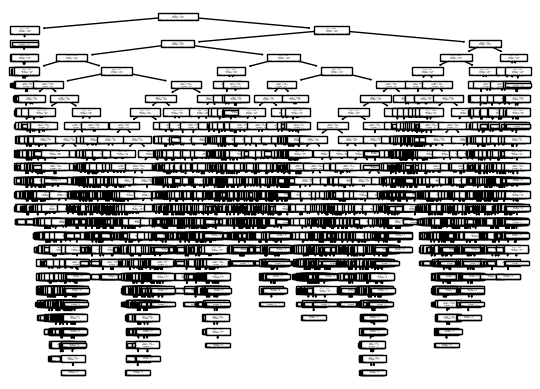

In [20]:
# dane bez skalowania
DD = tree.DecisionTreeClassifier(criterion='entropy', max_depth=26)
DD = DD.fit(train_inputs, train_classes)
tree.plot_tree(DD)

In [21]:
acc = accuracy_score(test_classes, DD.predict(test_inputs))
print('Dokładność: {:.2f}%'.format(acc * 100))
lista1.append(round(acc, 2))
print(confusion_matrix(test_classes, DD.predict(test_inputs)))

Dokładność: 68.73%
[[322   0   2   0   5  19   0   8   1]
 [  0 355   0   0   0   0   0   0   0]
 [  3   0 168   0  64  15   0  44  53]
 [  0   0   0 322   0   0   0   0   0]
 [  4   0  60   0 106   7   0  74  68]
 [ 17   0   8   0  10 240   0  26  13]
 [  0   0   0   0   0   0 317   0   0]
 [ 10   0  39   0  68  23   0 117  60]
 [  5   0  55   0 107  13   0  57 115]]


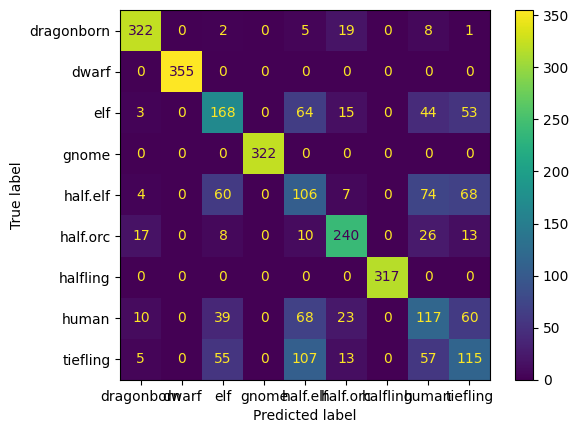

In [22]:
cm = confusion_matrix(test_classes, DD.predict(test_inputs), labels = DD.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = DD.classes_)
cm_display.plot()
plt.show()

[Text(0.6326675619628166, 0.98, 'x[0] <= 0.291\nentropy = 3.169\nsamples = 7000\nvalue = [787, 740, 765, 799, 767, 753, 818, 803, 768]'),
 Text(0.3590776092789036, 0.94, 'x[0] <= -1.299\nentropy = 2.598\nsamples = 4623\nvalue = [787, 8, 741, 0, 765, 753, 0, 803, 766]'),
 Text(0.10907264932741635, 0.9, 'x[0] <= -1.718\nentropy = 1.86\nsamples = 1506\nvalue = [736, 0, 36, 0, 71, 463, 0, 149, 51]'),
 Text(0.03430049113909292, 0.86, 'x[0] <= -2.024\nentropy = 1.238\nsamples = 851\nvalue = [562, 0, 4, 0, 7, 239, 0, 32, 7]'),
 Text(0.012212894951614784, 0.82, 'x[1] <= -0.321\nentropy = 0.917\nsamples = 489\nvalue = [364, 0, 0, 0, 1, 117, 0, 7, 0]'),
 Text(0.0044304535385332865, 0.78, 'x[3] <= -0.816\nentropy = 0.625\nsamples = 129\nvalue = [115, 0, 0, 0, 1, 9, 0, 4, 0]'),
 Text(0.002331817651859625, 0.74, 'x[3] <= -1.652\nentropy = 1.017\nsamples = 34\nvalue = [27, 0, 0, 0, 1, 2, 0, 4, 0]'),
 Text(0.0013990905911157748, 0.7, 'x[3] <= -1.725\nentropy = 1.299\nsamples = 8\nvalue = [5, 0, 0, 0,

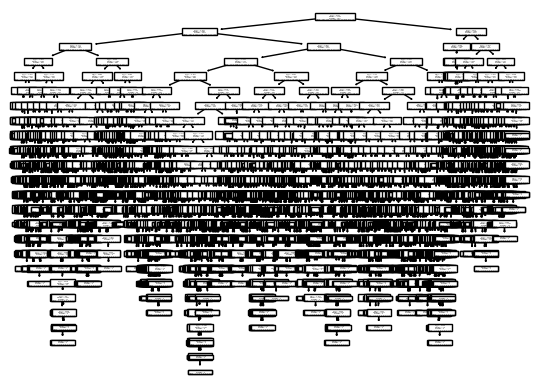

In [23]:
# dane znormalizowane
DD2 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=26)
DD2 = DD2.fit(train_inputs2, train_classes2)
tree.plot_tree(DD2)

In [24]:
acc2 = accuracy_score(test_classes2, DD2.predict(test_inputs2))
print('Dokładność: {:.2f}%'.format(acc2 * 100))
lista2.append(round(acc2, 2))
print(confusion_matrix(test_classes2, DD2.predict(test_inputs2)))

Dokładność: 49.43%
[[218   0   8   0   6  90   0  25  10]
 [  0 345   8   1   0   0   0   0   1]
 [  6   2 120   0  68  33   0  51  67]
 [  0   2   0 231   0   0  89   0   0]
 [  7   0  67   0  66  30   0  72  77]
 [104   0  24   0  32  90   0  44  20]
 [  0   1   0  99   0   0 217   0   0]
 [ 22   0  50   0  62  44   0  84  55]
 [  8   0  67   0  68  35   0  62 112]]


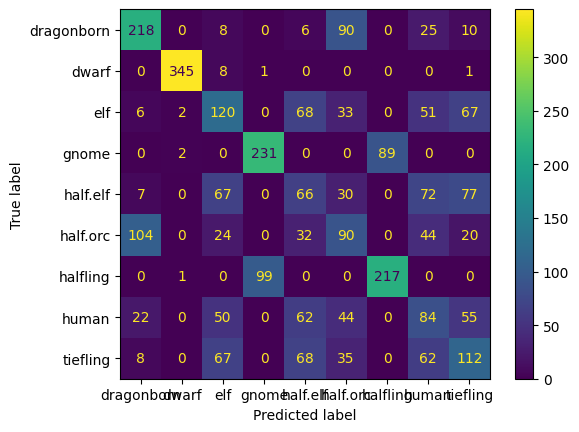

In [25]:
cm2 = confusion_matrix(test_classes2, DD2.predict(test_inputs2), labels = DD2.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = DD2.classes_)
cm_display.plot()
plt.show()

### Naiwny Bayes

In [26]:
# dane bez skalowania
NB = GaussianNB()
NB.fit(train_inputs, train_classes)
acc = accuracy_score(test_classes, NB.predict(test_inputs))
print('Dokładność: {:.2f}%'.format(acc * 100))
lista1.append(round(acc, 2))
print(confusion_matrix(test_classes, NB.predict(test_inputs)))

Dokładność: 60.80%
[[311   0   0   0   0  36   0   6   4]
 [  0 355   0   0   0   0   0   0   0]
 [  9   0 170   0  45  17   0  51  55]
 [  0   0   0 293   0   0  29   0   0]
 [  2   0  75   0  70  16   0  76  80]
 [100   0  11   0  17 113   0  67   6]
 [  0   0   0  20   0   0 297   0   0]
 [ 21   0  65   0  47  29   0 102  53]
 [  9   0  72   0  86  18   0  54 113]]


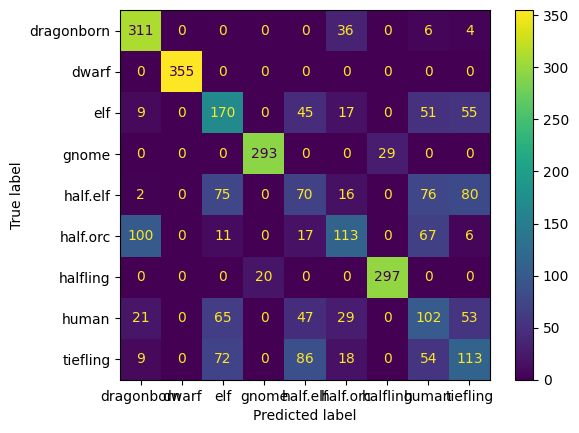

In [27]:
cm = confusion_matrix(test_classes, NB.predict(test_inputs), labels = NB.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = NB.classes_)
cm_display.plot()
plt.show()
# dwarf klasyfikuje dobrze

In [28]:
# dane znormalizowane
NB2 = GaussianNB()
NB2.fit(train_inputs2, train_classes2)
acc2 = accuracy_score(test_classes2, NB2.predict(test_inputs2))
print('Dokładność: {:.2f}%'.format(acc2 * 100))
lista2.append(round(acc2, 2))
print(confusion_matrix(test_classes2, NB2.predict(test_inputs2)))

Dokładność: 54.23%
[[270   0   3   0   6  51   0  18   9]
 [  0 351   3   1   0   0   0   0   0]
 [  2   1 178   0  34  22   0  51  59]
 [  0   1   0 224   0   0  97   0   0]
 [ 10   0  67   0  60  24   0  80  78]
 [102   0  25   0  14 101   0  60  12]
 [  0   0   0  92   0   0 225   0   0]
 [ 16   2  47   0  37  49   0 110  56]
 [  6   0  78   0  69  28   0  63 108]]


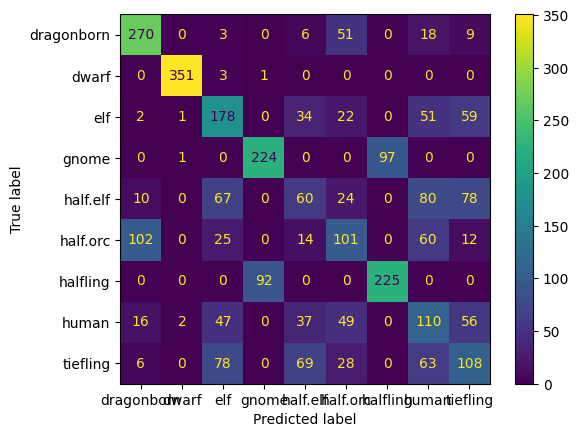

In [29]:
cm2 = confusion_matrix(test_classes2, NB2.predict(test_inputs2), labels = NB2.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = NB2.classes_)
cm_display.plot()
plt.show()

### k-najbliższych sąsiadów, k = 3

In [30]:
# dane bez skalowania
NN3 = KNeighborsClassifier(n_neighbors=3)
NN3.fit(train_inputs, train_classes)
acc = accuracy_score(test_classes, NN3.predict(test_inputs))
print('Dokładność: {:.2f}%'.format(acc * 100))
lista1.append(round(acc, 2))
print(confusion_matrix(test_classes, NN3.predict(test_inputs)))

Dokładność: 60.70%
[[312   0   3   0   2  31   0   7   2]
 [  0 355   0   0   0   0   0   0   0]
 [ 19   0 179   0  78   6   0  30  35]
 [  0   0   0 304   0   0  18   0   0]
 [ 10   0 109   0 100   8   0  40  52]
 [ 98   0  29   0  18 138   0  24   7]
 [  0   0   0   8   0   0 309   0   0]
 [ 33   0  85   0  83  18   0  53  45]
 [ 16   0 113   0  95  12   0  45  71]]


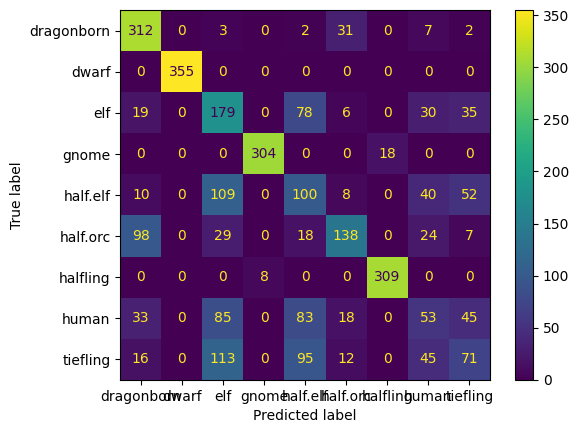

In [31]:
cm = confusion_matrix(test_classes, NN3.predict(test_inputs), labels = NN3.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = NN3.classes_)
cm_display.plot()
plt.show()

In [32]:
# dane znormalizowane
NN32 = KNeighborsClassifier(n_neighbors=3)
NN32.fit(train_inputs2, train_classes2)
acc2 = accuracy_score(test_classes2, NN32.predict(test_inputs2))
print('Dokładność: {:.2f}%'.format(acc2 * 100))
lista2.append(round(acc2, 2))
print(confusion_matrix(test_classes2, NN32.predict(test_inputs2)))

Dokładność: 45.17%
[[232   0  12   0  13  73   0  18   9]
 [  0 352   1   0   0   0   0   1   1]
 [ 20   9 150   0  69  29   0  38  32]
 [  0   0   0 179   0   0 143   0   0]
 [ 20   1 108   0  85  20   0  37  48]
 [128   0  45   0  38  58   0  32  13]
 [  0   1   0 131   0   0 185   0   0]
 [ 38   1  84   0  75  33   0  51  35]
 [ 24   0 123   0  98  18   0  26  63]]


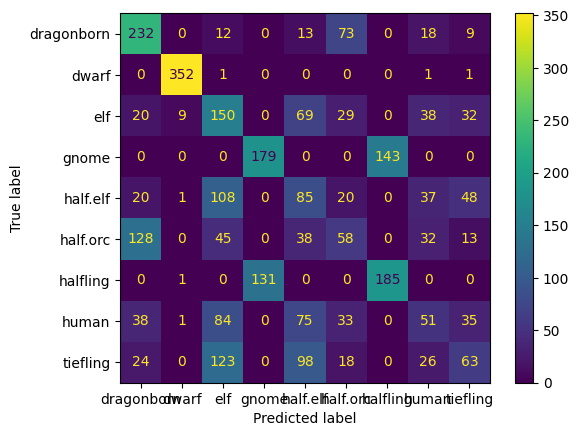

In [33]:
cm2 = confusion_matrix(test_classes2, NN32.predict(test_inputs2), labels = NN32.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = NN32.classes_)
cm_display.plot()
plt.show()

### k-najbliższych sąsiadów, k = 5

In [34]:
# dane bez skalowania
NN5 = KNeighborsClassifier(n_neighbors=5)
NN5.fit(train_inputs, train_classes)
acc = accuracy_score(test_classes, NN5.predict(test_inputs))
print('Dokładność: {:.2f}%'.format(acc * 100))
lista1.append(round(acc, 2))
print(confusion_matrix(test_classes, NN5.predict(test_inputs)))

Dokładność: 61.53%
[[316   0   2   0   1  31   0   4   3]
 [  0 355   0   0   0   0   0   0   0]
 [ 20   0 164   0  73   8   0  40  42]
 [  0   0   0 307   0   0  15   0   0]
 [ 10   0  84   0 102   9   0  56  58]
 [ 87   0  26   0  12 160   0  20   9]
 [  0   0   0   8   0   0 309   0   0]
 [ 31   0  56   0  93  23   0  66  48]
 [ 11   0  84   0 111  18   0  61  67]]


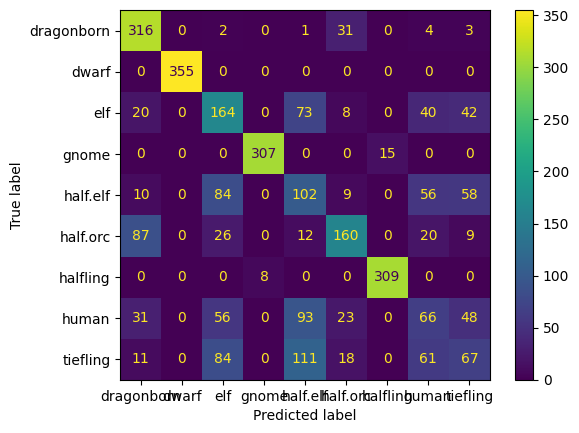

In [35]:
cm = confusion_matrix(test_classes, NN5.predict(test_inputs), labels = NN5.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = NN5.classes_)
cm_display.plot()
plt.show()

In [36]:
# dane znormalizowane
NN52 = KNeighborsClassifier(n_neighbors=5)
NN52.fit(train_inputs2, train_classes2)
acc2 = accuracy_score(test_classes2, NN52.predict(test_inputs2))
print('Dokładność: {:.2f}%'.format(acc2 * 100))
lista2.append(round(acc2, 2))
print(confusion_matrix(test_classes2, NN52.predict(test_inputs2)))

Dokładność: 47.53%
[[243   0   9   0  16  66   0  16   7]
 [  0 351   2   0   0   1   0   0   1]
 [ 16   4 135   0  63  28   0  56  45]
 [  0   0   0 184   0   0 138   0   0]
 [ 12   0  64   0  99  23   0  62  59]
 [121   0  31   0  38  72   0  41  11]
 [  0   0   0 121   0   0 196   0   0]
 [ 23   1  68   0  72  41   0  74  38]
 [ 12   0  77   0 107  21   0  63  72]]


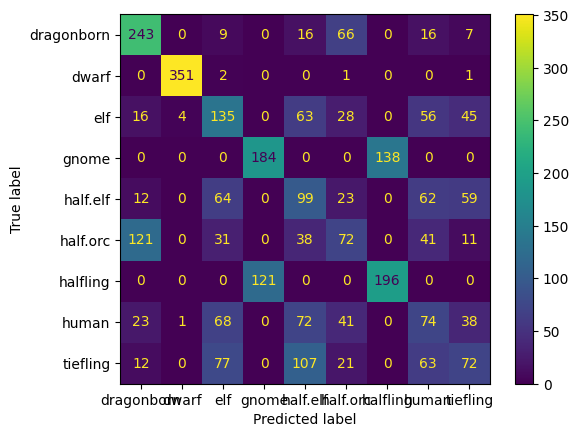

In [37]:
cm2 = confusion_matrix(test_classes2, NN52.predict(test_inputs2), labels = NN52.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = NN52.classes_)
cm_display.plot()
plt.show()

### k-najbliższych sąsiadów, k = 11

In [38]:
# dane bez skalowania
NN11 = KNeighborsClassifier(n_neighbors=11)
NN11.fit(train_inputs, train_classes)
acc = accuracy_score(test_classes, NN11.predict(test_inputs))
print('Dokładność: {:.2f}%'.format(acc * 100))
lista1.append(round(acc, 2))
print(confusion_matrix(test_classes, NN11.predict(test_inputs)))

Dokładność: 62.33%
[[330   0   4   0   3  17   0   3   0]
 [  0 355   0   0   0   0   0   0   0]
 [ 18   0 157   0  64  11   0  51  46]
 [  0   0   0 309   0   0  13   0   0]
 [ 12   0  74   0 103   6   0  52  72]
 [105   0  16   0  16 149   0  23   5]
 [  0   0   0   7   0   0 310   0   0]
 [ 29   0  51   0  88  27   0  66  56]
 [ 15   0  66   0 107  16   0  57  91]]


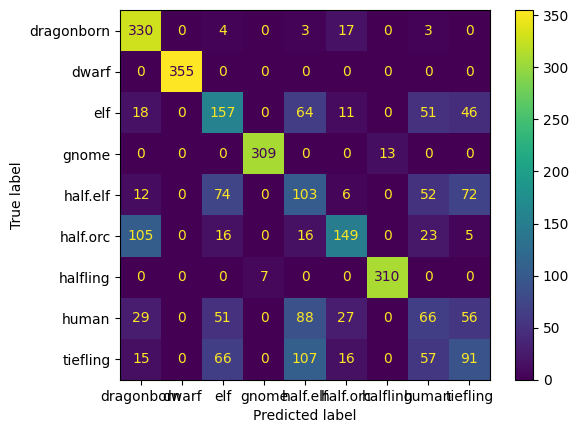

In [39]:
cm = confusion_matrix(test_classes, NN11.predict(test_inputs), labels = NN11.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = NN11.classes_)
cm_display.plot()
plt.show()

In [40]:
# dane znormalizowane
NN112 = KNeighborsClassifier(n_neighbors=11)
NN112.fit(train_inputs2, train_classes2)
acc2 = accuracy_score(test_classes2, NN112.predict(test_inputs2))
print('Dokładność: {:.2f}%'.format(acc2 * 100))
lista2.append(round(acc2, 2))
print(confusion_matrix(test_classes2, NN112.predict(test_inputs2)))

Dokładność: 48.53%
[[241   0   8   0  18  69   0  10  11]
 [  0 352   3   0   0   0   0   0   0]
 [ 13   4 141   0  57  28   0  53  51]
 [  0   0   0 189   0   0 133   0   0]
 [ 10   0  67   0  87  22   0  64  69]
 [118   0  29   0  29  89   0  36  13]
 [  0   0   0 113   0   0 204   0   0]
 [ 16   1  71   0  66  47   0  74  42]
 [  5   0  78   0 107  23   0  60  79]]


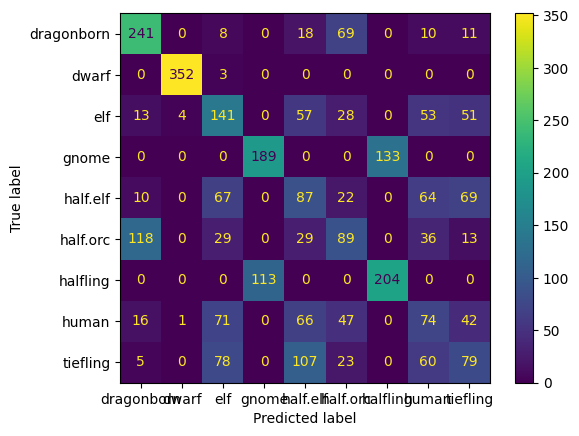

In [41]:
cm2 = confusion_matrix(test_classes2, NN112.predict(test_inputs2), labels = NN112.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = NN112.classes_)
cm_display.plot()
plt.show()

### Sieć neuronowa

In [42]:
# dane bez skalowania
label_encoder = LabelEncoder()
train_classes_encoded = label_encoder.fit_transform(train_classes)
train_classes_binary = to_categorical(train_classes_encoded)
print('Etykieta', train_classes[0], 'w postaci binarnej:', train_classes_binary[0])
test_classes_encoded = label_encoder.fit_transform(test_classes)
test_classes_binary = to_categorical(test_classes_encoded)
print('Etykieta', test_classes[0], 'w postaci binarnej:', test_classes_binary[0])

Etykieta gnome w postaci binarnej: [0. 0. 0. 1. 0. 0. 0. 0. 0.]
Etykieta human w postaci binarnej: [0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [43]:
# mamy 9 unikalnych etykiet, warstwa wyjściowa sieci ma dziewięć neuronów:
# każdy zwraca liczbę, którą należy przybliżyć do 0 (nie ta klasa postaci) lub 1 (to ta klasa postaci)
# input_shape jest równy ilości kolumn w test i train inputs
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(9,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
train_classes_binary = tf.convert_to_tensor(train_classes_binary, dtype=tf.float32)
train_inputs = tf.convert_to_tensor(train_inputs, dtype=tf.float32)
model.fit(train_inputs, train_classes_binary, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 3.0238 - accuracy: 0.3311
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 1.3627 - accuracy: 0.4489
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 1.2382 - accuracy: 0.5026
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1737 - accuracy: 0.5254
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1152 - accuracy: 0.5576
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0563 - accuracy: 0.5779
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0288 - accuracy: 0.5914
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0108 - accuracy: 0.5951
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0069 - accuracy: 0.5951
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9644 - accuracy: 0.6033

In [45]:
test_classes_binary = tf.convert_to_tensor(test_classes_binary, dtype=tf.float32)
test_inputs = tf.convert_to_tensor(test_inputs, dtype=tf.float32)
test_loss, test_acc = model.evaluate(test_inputs, test_classes_binary, verbose = 0)
lista1.append(round(test_acc, 2))
print('Dokładność: {:.2f}%'.format(test_acc * 100))
print(confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1)))

Dokładność: 63.30%
94/94 [==============================] - 0s 906us/step
[[303   0   1   0   0  44   0   1   8]
 [  0 313   0   0   1  38   0   0   3]
 [ 12   0 253   0   2  20   0   6  54]
 [  0   0   0 321   0   0   1   0   0]
 [  3   0 146   0   6  27   0  15 122]
 [ 52  12  21   0   0 214   0   3  12]
 [  0   0   1   0   0   0 316   0   0]
 [ 16   2 120   0   4  56   0  25  94]
 [  5   0 151   0  11  29   0   8 148]]


94/94 [==============================] - 0s 896us/step


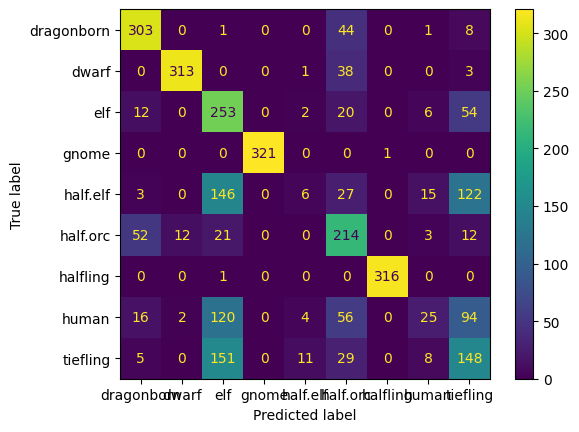

In [46]:
cm = confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8746 - accuracy: 0.6384 - val_loss: 0.8706 - val_accuracy: 0.6443
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8671 - accuracy: 0.6414 - val_loss: 0.8960 - val_accuracy: 0.6321
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8734 - accuracy: 0.6379 - val_loss: 0.9041 - val_accuracy: 0.6329
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8713 - accuracy: 0.6304 - val_loss: 0.9491 - val_accuracy: 0.6229
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8638 - accuracy: 0.6355 - val_loss: 0.9344 - val_accuracy: 0.6464
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8793 - accuracy: 0.6336 - val_loss: 0.9786 - val_accuracy: 0.5743
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8693 - accuracy: 0.6366 - val_loss: 0.9032 - val_accuracy: 0.6221
Epoch 

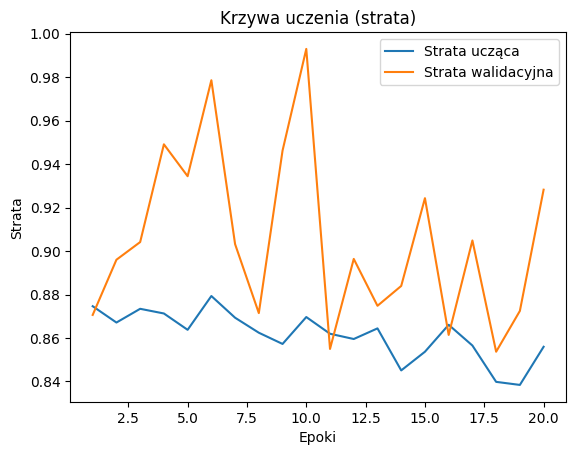

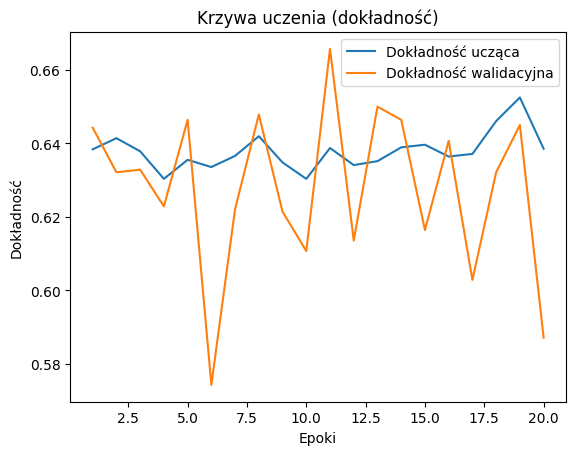

In [47]:
model.fit(train_inputs, train_classes_binary, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history = model.history.history
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Strata ucząca')
plt.plot(epochs, val_loss_values, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()
# jeśli wartość funkcji straty maleje na zbiorze treningowym, ale rośnie na zbiorze walidacyjnym,
# oznacza to, że sieć zaczyna się przeuczać i przestaje generalizować na nowe dane,
# należałoby przerwać uczenie gdy pomarańczowa linia zaczyna rosnąć

plt.plot(epochs, acc_values, label='Dokładność ucząca')
plt.plot(epochs, val_acc_values, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

In [48]:
# dane znormalizowane
label_encoder = LabelEncoder()
train_classes_encoded2 = label_encoder.fit_transform(train_classes2)
train_classes_binary2 = to_categorical(train_classes_encoded2)
print('Etykieta', train_classes2[0], 'w postaci binarnej:', train_classes_binary2[0])
test_classes_encoded2 = label_encoder.fit_transform(test_classes2)
test_classes_binary2 = to_categorical(test_classes_encoded2)
print('Etykieta', test_classes2[0], 'w postaci binarnej:', test_classes_binary2[0])

Etykieta gnome w postaci binarnej: [0. 0. 0. 1. 0. 0. 0. 0. 0.]
Etykieta human w postaci binarnej: [0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [49]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
train_classes_binary2 = tf.convert_to_tensor(train_classes_binary2, dtype=tf.float32)
train_inputs2 = tf.convert_to_tensor(train_inputs2, dtype=tf.float32)
model2.fit(train_inputs2, train_classes_binary2, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 1.6849 - accuracy: 0.3387
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1879 - accuracy: 0.5026
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0837 - accuracy: 0.5269
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0492 - accuracy: 0.5330
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0303 - accuracy: 0.5434
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0165 - accuracy: 0.5559
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0095 - accuracy: 0.5581
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0013 - accuracy: 0.5603
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9936 - accuracy: 0.5673
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9899 - accuracy: 0.5661

In [51]:
test_classes_binary2 = tf.convert_to_tensor(test_classes_binary2, dtype=tf.float32)
test_inputs2 = tf.convert_to_tensor(test_inputs2, dtype=tf.float32)
test_loss2, test_acc2 = model2.evaluate(test_inputs2, test_classes_binary2, verbose = 0)
lista2.append(round(test_acc2, 2))
print('Dokładność: {:.2f}%'.format(test_acc2 * 100))
print(confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1)))

Dokładność: 56.13%
94/94 [==============================] - 0s 1ms/step
[[317   0   0   0   3  26   0   8   3]
 [  0 355   0   0   0   0   0   0   0]
 [  9   2 145   0  69  18   0  73  31]
 [  0   0   0 213   0   0 109   0   0]
 [  6   0  68   0  97  12   0  92  44]
 [127   0  12   0  22  78   0  68   7]
 [  0   0   0  22   0   0 295   0   0]
 [ 22   0  46   0  61  34   0 121  33]
 [ 12   0  58   0 118  18   0  83  63]]


94/94 [==============================] - 0s 2ms/step


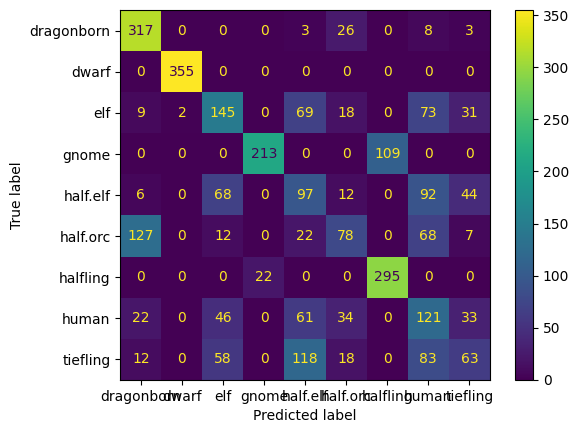

In [52]:
cm2 = confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9338 - accuracy: 0.5961 - val_loss: 0.9770 - val_accuracy: 0.5850
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9321 - accuracy: 0.6016 - val_loss: 0.9700 - val_accuracy: 0.6000
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9290 - accuracy: 0.6023 - val_loss: 0.9706 - val_accuracy: 0.6100
Epoch 4/20
175/175 [==============================] - 0s 3ms/step - loss: 0.9265 - accuracy: 0.6027 - val_loss: 0.9725 - val_accuracy: 0.5943
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9253 - accuracy: 0.6025 - val_loss: 0.9788 - val_accuracy: 0.5929
Epoch 6/20
175/175 [==============================] - 1s 3ms/step - loss: 0.9228 - accuracy: 0.6034 - val_loss: 0.9820 - val_accuracy: 0.5979
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9164 - accuracy: 0.6098 - val_loss: 0.9876 - val_accuracy: 0.5886
Epoch 

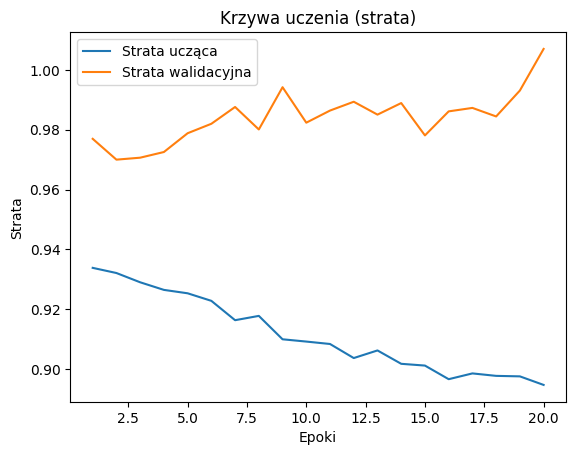

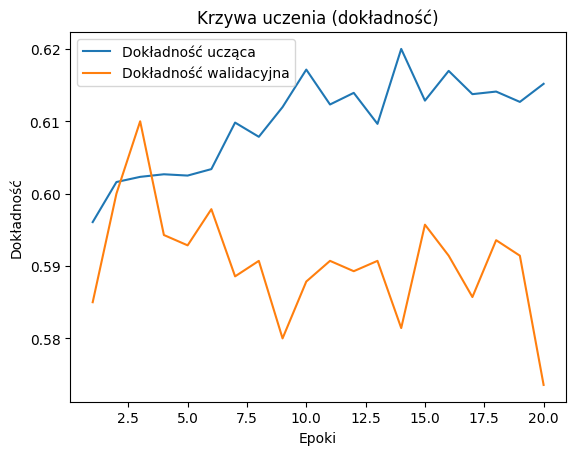

In [53]:
model2.fit(train_inputs2, train_classes_binary2, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history2 = model2.history.history
loss_values2 = history2['loss']
val_loss_values2 = history2['val_loss']
acc_values2 = history2['accuracy']
val_acc_values2 = history2['val_accuracy']
epochs2 = range(1, len(loss_values2) + 1)

plt.plot(epochs2, loss_values2, label='Strata ucząca')
plt.plot(epochs2, val_loss_values2, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()
# sieć jest przeuczona

plt.plot(epochs2, acc_values2, label='Dokładność ucząca')
plt.plot(epochs2, val_acc_values2, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

### Sieć neuronowa (2) z większą liczbą warstw ukrytych

In [54]:
# dane bez skalowania
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(9,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_inputs, train_classes_binary, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 2s 2ms/step - loss: 1.7944 - accuracy: 0.3839
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 1.1971 - accuracy: 0.4937
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 1.0495 - accuracy: 0.5643
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.5826
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9901 - accuracy: 0.5746
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9465 - accuracy: 0.5881
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.9418 - accuracy: 0.5904
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9400 - accuracy: 0.5897
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.9075 - accuracy: 0.6054
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9225 - accuracy: 0.5940

In [55]:
test_loss, test_acc = model.evaluate(test_inputs, test_classes_binary, verbose = 0)
lista1.append(round(test_acc, 2))
print('Dokładność: {:.2f}%'.format(test_acc * 100))
print(confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1)))

Dokładność: 55.63%
94/94 [==============================] - 0s 2ms/step
[[340   0   1   0   1   0   0  14   1]
 [  0 207   0   0   6  97   0  45   0]
 [ 24   0 156   0  67   0   0  61  39]
 [  0   0   0 322   0   0   0   0   0]
 [ 15   0  63   0 115   0   0  84  42]
 [187   1   6   0   8  25   0  81   6]
 [  0   0   0   3   0   0 314   0   0]
 [ 44   0  38   0  68   0   0 133  34]
 [ 20   0  59   0 149   0   0  67  57]]


94/94 [==============================] - 0s 1ms/step


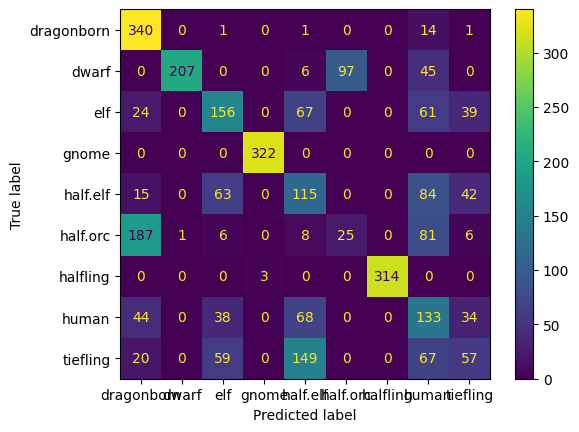

In [56]:
cm = confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 1s 3ms/step - loss: 0.8319 - accuracy: 0.6425 - val_loss: 0.8481 - val_accuracy: 0.6421
Epoch 2/20
175/175 [==============================] - 0s 3ms/step - loss: 0.8377 - accuracy: 0.6345 - val_loss: 0.8529 - val_accuracy: 0.6193
Epoch 3/20
175/175 [==============================] - 1s 4ms/step - loss: 0.8384 - accuracy: 0.6346 - val_loss: 0.9560 - val_accuracy: 0.5921
Epoch 4/20
175/175 [==============================] - 0s 3ms/step - loss: 0.8255 - accuracy: 0.6498 - val_loss: 0.8582 - val_accuracy: 0.6471
Epoch 5/20
175/175 [==============================] - 1s 3ms/step - loss: 0.8200 - accuracy: 0.6550 - val_loss: 0.8315 - val_accuracy: 0.6493
Epoch 6/20
175/175 [==============================] - 1s 3ms/step - loss: 0.8310 - accuracy: 0.6409 - val_loss: 0.8673 - val_accuracy: 0.6257
Epoch 7/20
175/175 [==============================] - 0s 3ms/step - loss: 0.8284 - accuracy: 0.6425 - val_loss: 0.8904 - val_accuracy: 0.6179
Epoch 

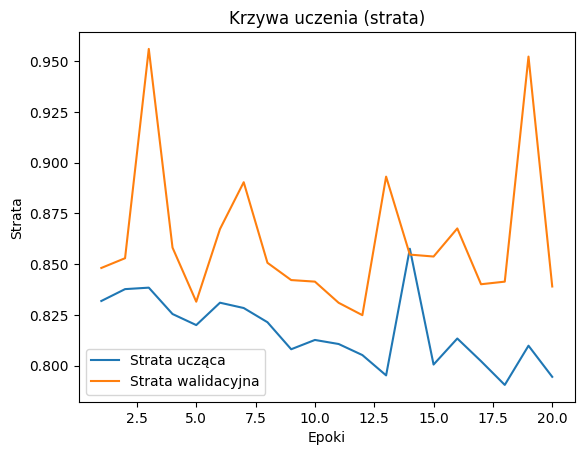

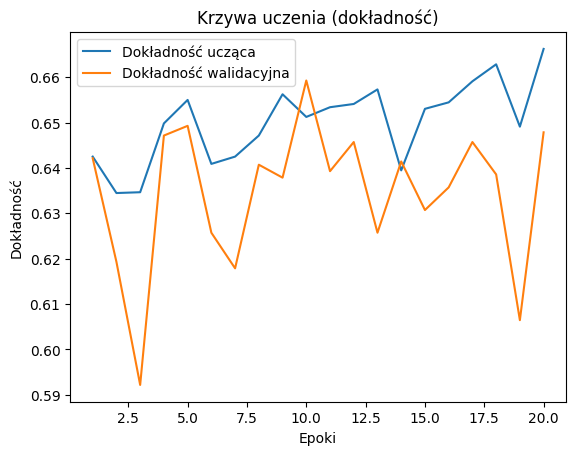

In [57]:
model.fit(train_inputs, train_classes_binary, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history = model.history.history
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Strata ucząca')
plt.plot(epochs, val_loss_values, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, label='Dokładność ucząca')
plt.plot(epochs, val_acc_values, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

In [58]:
# dane znormalizowane
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(7,)))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(9, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_inputs2, train_classes_binary2, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 2s 2ms/step - loss: 1.3743 - accuracy: 0.4321
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 1.0690 - accuracy: 0.5261
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 1.0329 - accuracy: 0.5406
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 1.0201 - accuracy: 0.5486
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 1.0148 - accuracy: 0.5491
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0059 - accuracy: 0.5556
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9916 - accuracy: 0.5627
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9863 - accuracy: 0.5620
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9787 - accuracy: 0.5721
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9707 - accuracy: 0.5716

In [59]:
test_loss2, test_acc2 = model2.evaluate(test_inputs2, test_classes_binary2, verbose = 0)
lista2.append(round(test_acc2, 2))
print('Dokładność: {:.2f}%'.format(test_acc2 * 100))
print(confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1)))

Dokładność: 55.73%
94/94 [==============================] - 0s 961us/step
[[276   0   0   0   1  68   0   6   6]
 [  0 354   0   0   0   0   0   1   0]
 [  6   0  90   0  83  31   0  79  58]
 [  0   0   0 299   0   0  23   0   0]
 [  3   0  32   0  74  31   0  99  80]
 [104   0   2   0  28 119   0  50  11]
 [  0   0   0  99   0   0 218   0   0]
 [ 11   0  20   0  52  56   0 126  52]
 [  7   0  26   0  91  36   0  76 116]]


94/94 [==============================] - 0s 1ms/step


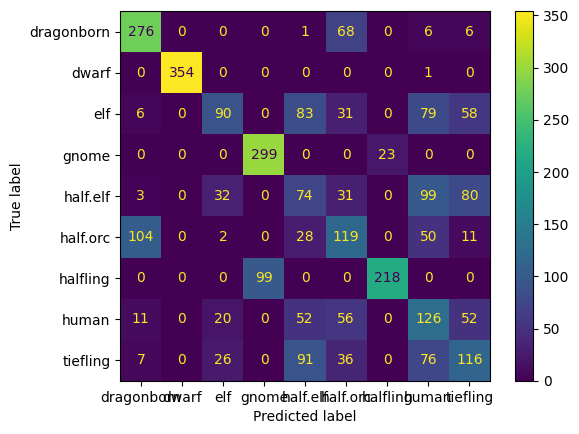

In [60]:
cm2 = confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9079 - accuracy: 0.6068 - val_loss: 0.9185 - val_accuracy: 0.6079
Epoch 2/20
175/175 [==============================] - 0s 3ms/step - loss: 0.8945 - accuracy: 0.6157 - val_loss: 0.9390 - val_accuracy: 0.6029
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8917 - accuracy: 0.6154 - val_loss: 0.9570 - val_accuracy: 0.5864
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8858 - accuracy: 0.6184 - val_loss: 0.9554 - val_accuracy: 0.5950
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8779 - accuracy: 0.6270 - val_loss: 0.9396 - val_accuracy: 0.5993
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8774 - accuracy: 0.6264 - val_loss: 0.9541 - val_accuracy: 0.5943
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8698 - accuracy: 0.6293 - val_loss: 0.9758 - val_accuracy: 0.5921
Epoch 

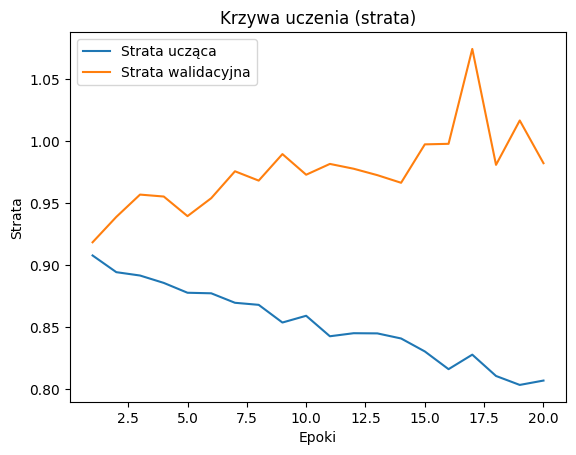

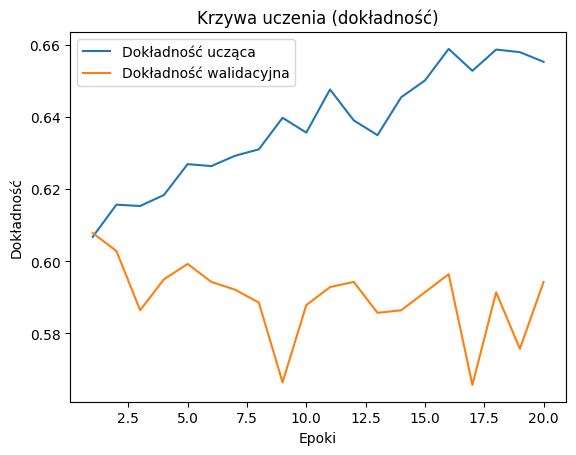

In [61]:
model2.fit(train_inputs2, train_classes_binary2, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history2 = model2.history.history
loss_values2 = history2['loss']
val_loss_values2 = history2['val_loss']
acc_values2 = history2['accuracy']
val_acc_values2 = history2['val_accuracy']
epochs2 = range(1, len(loss_values2) + 1)

plt.plot(epochs2, loss_values2, label='Strata ucząca')
plt.plot(epochs2, val_loss_values2, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()
# funkcja straty na zbiorze walidacyjnym rośnie, sieć zaczyna się przeuczać

plt.plot(epochs2, acc_values2, label='Dokładność ucząca')
plt.plot(epochs2, val_acc_values2, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

### Sieć neuronowa (3) z inną funkcją aktywacji

In [62]:
# dane bez skalowania
# zmieniamy relu na sigmoid
model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(9,)))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_inputs, train_classes_binary, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 1.8478 - accuracy: 0.2987
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 1.4355 - accuracy: 0.4856
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 1.2429 - accuracy: 0.5097
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1529 - accuracy: 0.5403
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 1.0913 - accuracy: 0.5619
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0446 - accuracy: 0.5803
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0037 - accuracy: 0.5916
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9700 - accuracy: 0.6004
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9511 - accuracy: 0.6013
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.9308 - accuracy: 0.6143

In [63]:
test_loss, test_acc = model.evaluate(test_inputs, test_classes_binary, verbose = 0)
lista1.append(round(test_acc, 2))
print('Dokładność: {:.2f}%'.format(test_acc * 100))
print(confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1)))

Dokładność: 64.23%
94/94 [==============================] - 0s 784us/step
[[312   0   1   0   0  31   0   8   5]
 [  0 326   0   0   0  24   0   5   0]
 [ 18   0 183   0  10   6   0  52  78]
 [  0   0   0 322   0   0   0   0   0]
 [ 11   0  80   0  20  11   0  69 128]
 [ 62  16   8   0   0 182   0  31  15]
 [  0   0   0   0   0   0 317   0   0]
 [ 22   2  61   0  13  32   0 108  79]
 [ 12   0  77   0  22  11   0  73 157]]


94/94 [==============================] - 0s 863us/step


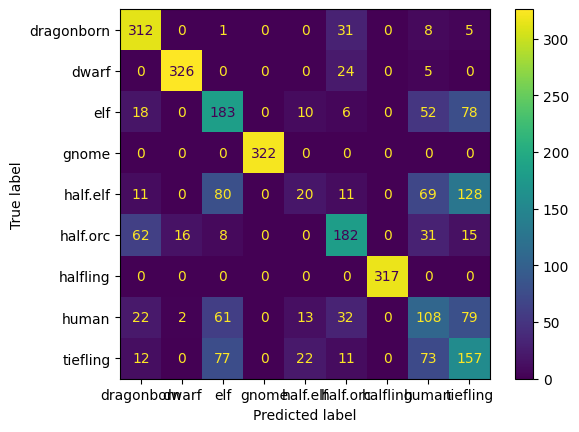

In [64]:
cm = confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8395 - accuracy: 0.6371 - val_loss: 0.8675 - val_accuracy: 0.6529
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8473 - accuracy: 0.6357 - val_loss: 0.8666 - val_accuracy: 0.6393
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8330 - accuracy: 0.6407 - val_loss: 0.8558 - val_accuracy: 0.6571
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8377 - accuracy: 0.6382 - val_loss: 0.9002 - val_accuracy: 0.6064
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8306 - accuracy: 0.6488 - val_loss: 0.8503 - val_accuracy: 0.6543
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8306 - accuracy: 0.6432 - val_loss: 0.8479 - val_accuracy: 0.6507
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8224 - accuracy: 0.6489 - val_loss: 0.8488 - val_accuracy: 0.6529
Epoch 

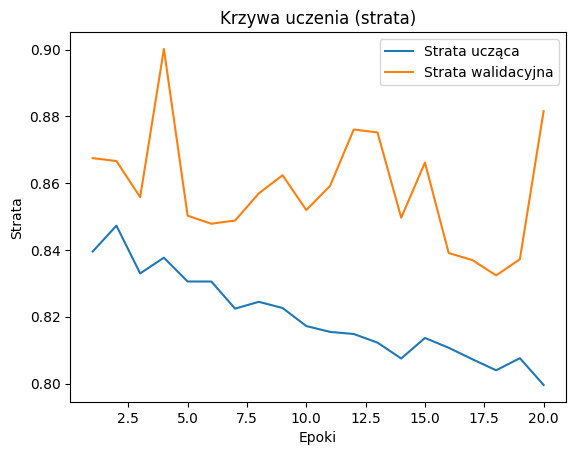

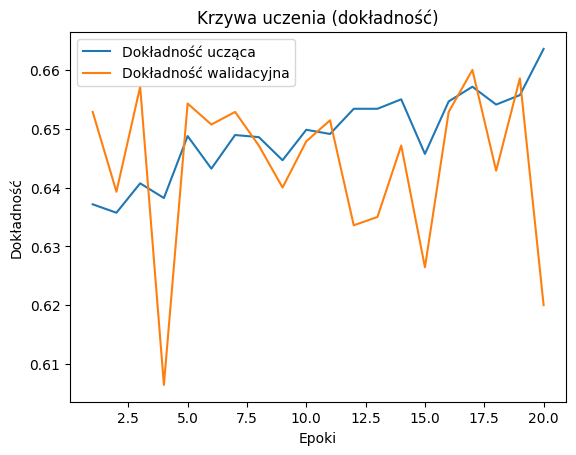

In [65]:
model.fit(train_inputs, train_classes_binary, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history = model.history.history
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Strata ucząca')
plt.plot(epochs, val_loss_values, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, label='Dokładność ucząca')
plt.plot(epochs, val_acc_values, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

In [66]:
# dane znormalizowane
model2 = Sequential()
model2.add(Dense(64, activation='sigmoid', input_shape=(7,)))
model2.add(Dense(32, activation='sigmoid'))
model2.add(Dense(9, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_inputs2, train_classes_binary2, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 2.0749 - accuracy: 0.2436
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 1.6410 - accuracy: 0.3801
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 1.4247 - accuracy: 0.4690
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 1.2993 - accuracy: 0.4901
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 1.2147 - accuracy: 0.5054
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1578 - accuracy: 0.5121
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1194 - accuracy: 0.5160
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0919 - accuracy: 0.5306
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0736 - accuracy: 0.5413
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0609 - accuracy: 0.5366

In [67]:
test_loss2, test_acc2 = model2.evaluate(test_inputs2, test_classes_binary2, verbose = 0)
lista2.append(round(test_acc2, 2))
print('Dokładność: {:.2f}%'.format(test_acc2 * 100))
print(confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1)))

Dokładność: 57.17%
94/94 [==============================] - 0s 977us/step
[[318   0   0   0   1  32   0   1   5]
 [  0 355   0   0   0   0   0   0   0]
 [ 10   1 182   0  36  27   0  48  43]
 [  0   0   0 225   0   0  97   0   0]
 [  8   0  83   0  73  31   0  65  59]
 [126   0  16   0  15 110   0  40   7]
 [  0   0   0  53   0   0 264   0   0]
 [ 22   0  62   0  43  54   0  88  48]
 [ 12   0  74   0  79  35   0  52 100]]


94/94 [==============================] - 0s 846us/step


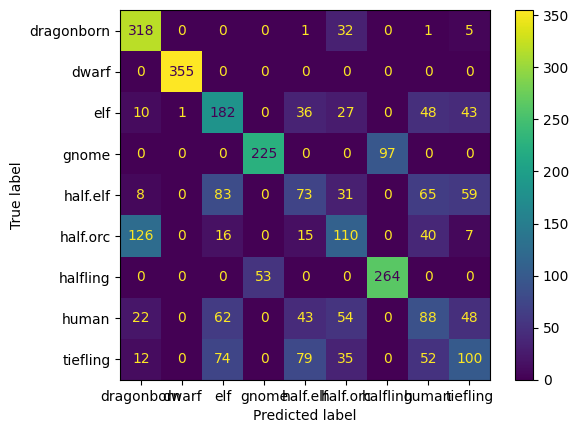

In [68]:
cm2 = confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9914 - accuracy: 0.5691 - val_loss: 1.0204 - val_accuracy: 0.5521
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5714 - val_loss: 1.0150 - val_accuracy: 0.5571
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9847 - accuracy: 0.5734 - val_loss: 1.0155 - val_accuracy: 0.5686
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9812 - accuracy: 0.5752 - val_loss: 1.0101 - val_accuracy: 0.5657
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9799 - accuracy: 0.5732 - val_loss: 1.0073 - val_accuracy: 0.5614
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9749 - accuracy: 0.5823 - val_loss: 1.0088 - val_accuracy: 0.5657
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9727 - accuracy: 0.5836 - val_loss: 1.0031 - val_accuracy: 0.5629
Epoch 

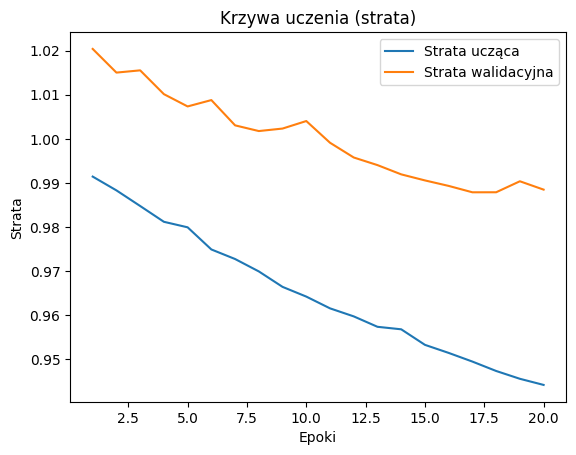

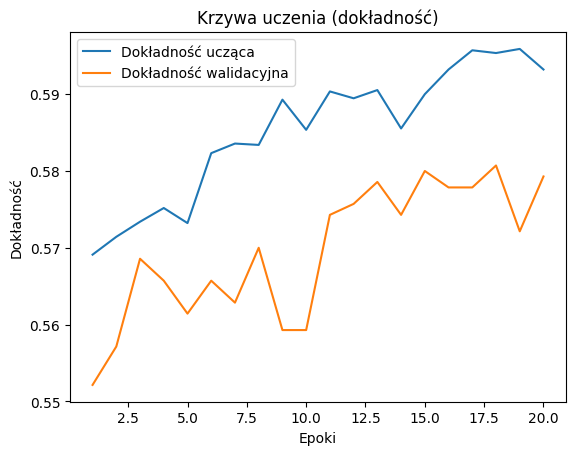

In [69]:
model2.fit(train_inputs2, train_classes_binary2, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history2 = model2.history.history
loss_values2 = history2['loss']
val_loss_values2 = history2['val_loss']
acc_values2 = history2['accuracy']
val_acc_values2 = history2['val_accuracy']
epochs2 = range(1, len(loss_values2) + 1)

plt.plot(epochs2, loss_values2, label='Strata ucząca')
plt.plot(epochs2, val_loss_values2, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()
# wykres wskazuje na to, że sieć dobrze się uczy, ponieważ strata maleje na obu zbiorach

plt.plot(epochs2, acc_values2, label='Dokładność ucząca')
plt.plot(epochs2, val_acc_values2, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

### Sieć neuronowa (4) z większą liczbą epok

In [70]:
# dane bez skalowania
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_inputs, train_classes_binary, epochs=40, batch_size=32)

Epoch 1/40
219/219 [==============================] - 1s 1ms/step - loss: 3.2417 - accuracy: 0.3519
Epoch 2/40
219/219 [==============================] - 0s 2ms/step - loss: 1.2078 - accuracy: 0.5053
Epoch 3/40
219/219 [==============================] - 0s 2ms/step - loss: 1.1204 - accuracy: 0.5466
Epoch 4/40
219/219 [==============================] - 0s 1ms/step - loss: 1.0477 - accuracy: 0.5761
Epoch 5/40
219/219 [==============================] - 0s 2ms/step - loss: 1.0029 - accuracy: 0.5934
Epoch 6/40
219/219 [==============================] - 0s 1ms/step - loss: 0.9853 - accuracy: 0.6024
Epoch 7/40
219/219 [==============================] - 0s 1ms/step - loss: 0.9533 - accuracy: 0.6091
Epoch 8/40
219/219 [==============================] - 0s 1ms/step - loss: 0.9267 - accuracy: 0.6227
Epoch 9/40
219/219 [==============================] - 0s 1ms/step - loss: 0.9263 - accuracy: 0.6176
Epoch 10/40
219/219 [==============================] - 0s 2ms/step - loss: 0.9251 - accuracy: 0.6200

In [71]:
test_loss, test_acc = model.evaluate(test_inputs, test_classes_binary, verbose = 0)
lista1.append(round(test_acc, 2))
print('Dokładność: {:.2f}%'.format(test_acc * 100))
print(confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1)))

Dokładność: 66.27%
94/94 [==============================] - 0s 779us/step
[[322   0   0   0   0  20   0   9   6]
 [  0 340   0   0   0   9   0   6   0]
 [ 15   0 157   0   9  14   0  68  84]
 [  0   0   0 322   0   0   0   0   0]
 [  9   0  39   0  14  14   0 114 129]
 [ 51  25   4   0   0 192   0  31  11]
 [  0   0   0   0   0   0 317   0   0]
 [ 21   3  31   0   6  33   0 140  83]
 [ 12   0  45   0   8  19   0  84 184]]


94/94 [==============================] - 0s 868us/step


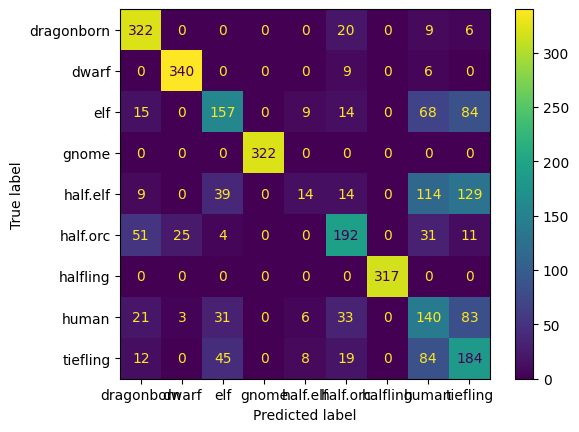

In [72]:
cm = confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8105 - accuracy: 0.6539 - val_loss: 0.8499 - val_accuracy: 0.6371
Epoch 2/40
175/175 [==============================] - 0s 3ms/step - loss: 0.8098 - accuracy: 0.6543 - val_loss: 0.8413 - val_accuracy: 0.6464
Epoch 3/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8179 - accuracy: 0.6513 - val_loss: 0.8510 - val_accuracy: 0.6236
Epoch 4/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8229 - accuracy: 0.6486 - val_loss: 0.8274 - val_accuracy: 0.6457
Epoch 5/40
175/175 [==============================] - 0s 2ms/step - loss: 0.7988 - accuracy: 0.6546 - val_loss: 0.8542 - val_accuracy: 0.6243
Epoch 6/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8020 - accuracy: 0.6587 - val_loss: 0.8643 - val_accuracy: 0.6521
Epoch 7/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8051 - accuracy: 0.6550 - val_loss: 0.8601 - val_accuracy: 0.6343
Epoch 

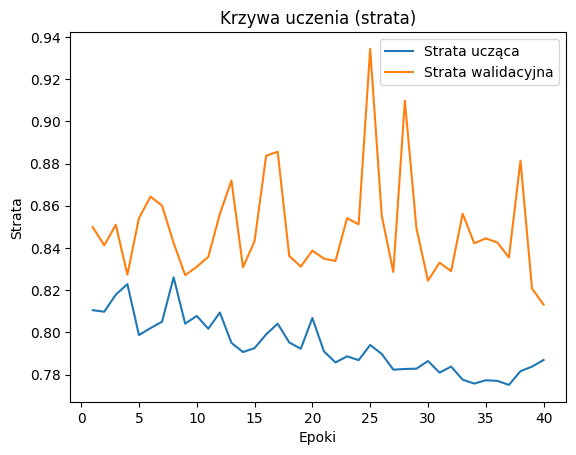

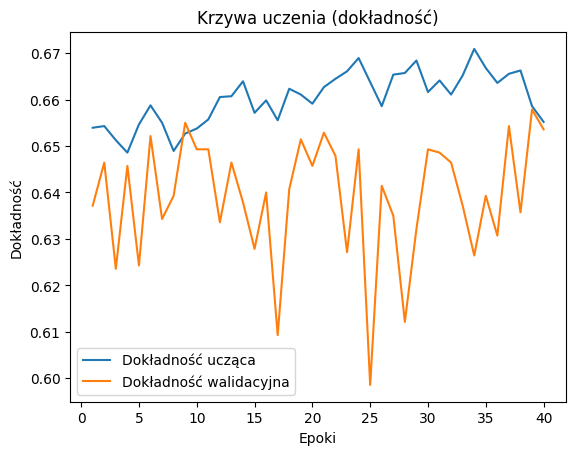

In [73]:
model.fit(train_inputs, train_classes_binary, validation_split=0.2, shuffle=True, epochs=40, batch_size=32)
history = model.history.history
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Strata ucząca')
plt.plot(epochs, val_loss_values, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, label='Dokładność ucząca')
plt.plot(epochs, val_acc_values, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

In [74]:
# dane znormalizowane
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(7,)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(9, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_inputs2, train_classes_binary2, epochs=40, batch_size=32)

Epoch 1/40
219/219 [==============================] - 1s 1ms/step - loss: 1.6257 - accuracy: 0.3443
Epoch 2/40
219/219 [==============================] - 0s 1ms/step - loss: 1.1856 - accuracy: 0.4981
Epoch 3/40
219/219 [==============================] - 0s 2ms/step - loss: 1.0847 - accuracy: 0.5274
Epoch 4/40
219/219 [==============================] - 0s 1ms/step - loss: 1.0485 - accuracy: 0.5416
Epoch 5/40
219/219 [==============================] - 0s 1ms/step - loss: 1.0277 - accuracy: 0.5444
Epoch 6/40
219/219 [==============================] - 0s 1ms/step - loss: 1.0174 - accuracy: 0.5523
Epoch 7/40
219/219 [==============================] - 0s 1ms/step - loss: 1.0083 - accuracy: 0.5576
Epoch 8/40
219/219 [==============================] - 0s 2ms/step - loss: 1.0041 - accuracy: 0.5573
Epoch 9/40
219/219 [==============================] - 0s 1ms/step - loss: 0.9977 - accuracy: 0.5637
Epoch 10/40
219/219 [==============================] - 0s 1ms/step - loss: 0.9905 - accuracy: 0.5636

In [75]:
test_loss2, test_acc2 = model2.evaluate(test_inputs2, test_classes_binary2, verbose = 0)
lista2.append(round(test_acc2, 2))
print('Dokładność: {:.2f}%'.format(test_acc2 * 100))
print(confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1)))

Dokładność: 57.70%
94/94 [==============================] - 0s 784us/step
[[288   0   0   0   2  60   0   4   3]
 [  0 355   0   0   0   0   0   0   0]
 [ 11   0 170   0  41  26   0  57  42]
 [  0   0   0 305   0   0  17   0   0]
 [  4   0  64   0  76  27   0  87  61]
 [107   0  17   0  15 129   0  36  10]
 [  0   0   0 102   0   0 215   0   0]
 [ 16   0  44   0  48  64   0  95  50]
 [  7   0  68   0  83  38   0  58  98]]


94/94 [==============================] - 0s 802us/step


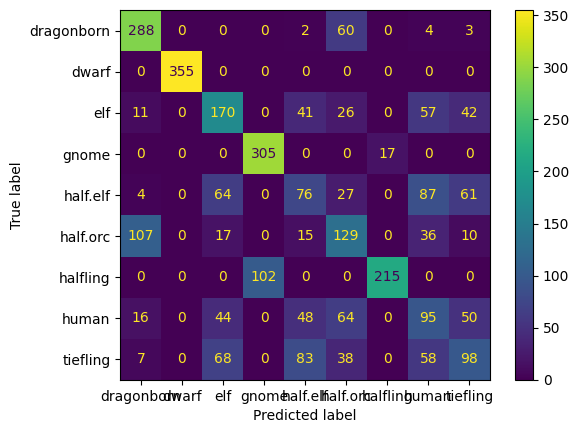

In [76]:
cm2 = confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8959 - accuracy: 0.6191 - val_loss: 0.9336 - val_accuracy: 0.6029
Epoch 2/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8975 - accuracy: 0.6164 - val_loss: 0.9400 - val_accuracy: 0.6093
Epoch 3/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8931 - accuracy: 0.6175 - val_loss: 0.9377 - val_accuracy: 0.6021
Epoch 4/40
175/175 [==============================] - 0s 1ms/step - loss: 0.8920 - accuracy: 0.6211 - val_loss: 0.9533 - val_accuracy: 0.6043
Epoch 5/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8887 - accuracy: 0.6211 - val_loss: 0.9506 - val_accuracy: 0.5936
Epoch 6/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8887 - accuracy: 0.6246 - val_loss: 0.9434 - val_accuracy: 0.6021
Epoch 7/40
175/175 [==============================] - 0s 2ms/step - loss: 0.8869 - accuracy: 0.6252 - val_loss: 0.9588 - val_accuracy: 0.6043
Epoch 

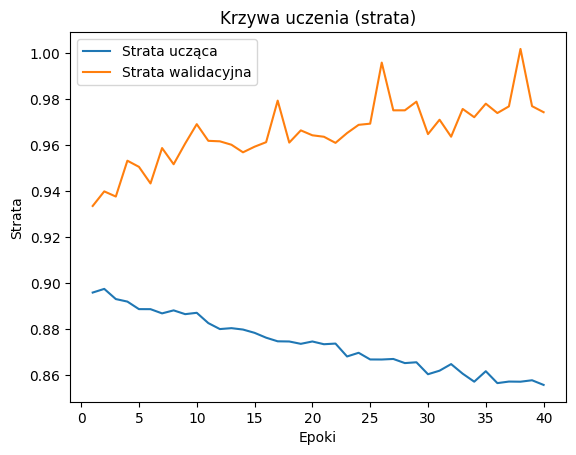

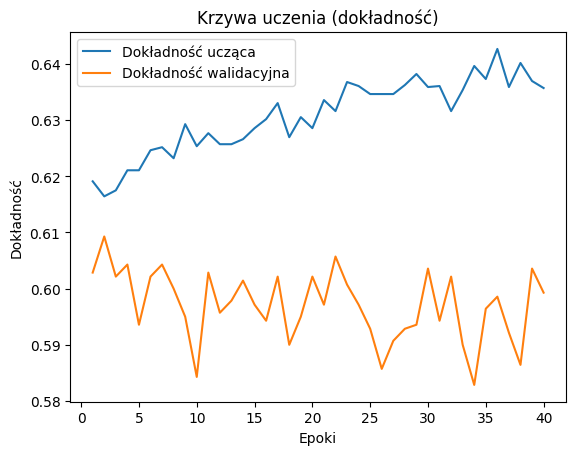

In [77]:
model2.fit(train_inputs2, train_classes_binary2, validation_split=0.2, shuffle=True, epochs=40, batch_size=32)
history2 = model2.history.history
loss_values2 = history2['loss']
val_loss_values2 = history2['val_loss']
acc_values2 = history2['accuracy']
val_acc_values2 = history2['val_accuracy']
epochs2 = range(1, len(loss_values2) + 1)

plt.plot(epochs2, loss_values2, label='Strata ucząca')
plt.plot(epochs2, val_loss_values2, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()
# sieć jest przeuczona

plt.plot(epochs2, acc_values2, label='Dokładność ucząca')
plt.plot(epochs2, val_acc_values2, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

### Sieć neuronowa (5) z innym optymalizatorem

In [78]:
# dane bez skalowania
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

# zmieniamy adam na rmsprop
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_inputs, train_classes_binary, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 2.9856 - accuracy: 0.3046
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 1.4573 - accuracy: 0.4306
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 1.3031 - accuracy: 0.4769
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 1.2022 - accuracy: 0.5209
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1123 - accuracy: 0.5483
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 1.0662 - accuracy: 0.5611
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0264 - accuracy: 0.5734
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0004 - accuracy: 0.5829
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9724 - accuracy: 0.5893
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9579 - accuracy: 0.5974

In [79]:
test_loss, test_acc = model.evaluate(test_inputs, test_classes_binary, verbose = 0)
lista1.append(round(test_acc, 2))
print('Dokładność: {:.2f}%'.format(test_acc * 100))
print(confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1)))

Dokładność: 63.67%
94/94 [==============================] - 0s 762us/step
[[321   0   1   0   0  19   0   1  15]
 [  0 343   0   0   0  10   0   0   2]
 [ 18   0 186   0   1   6   0   8 128]
 [  0   0   0 322   0   0   0   0   0]
 [  9   0  89   0   2  11   0  21 187]
 [ 77  37  14   0   0 143   0   9  34]
 [  0   0   0   0   0   0 317   0   0]
 [ 24   3  72   0   2  29   0  40 147]
 [  9   0  79   0   1  14   0  13 236]]


94/94 [==============================] - 0s 754us/step


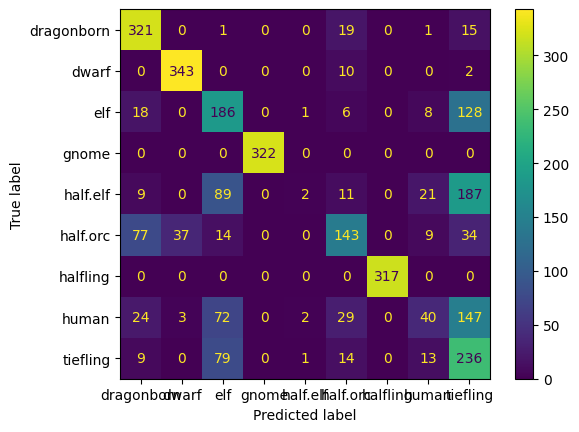

In [80]:
cm = confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8678 - accuracy: 0.6311 - val_loss: 0.9173 - val_accuracy: 0.5986
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8612 - accuracy: 0.6329 - val_loss: 0.8932 - val_accuracy: 0.6086
Epoch 3/20
175/175 [==============================] - 1s 4ms/step - loss: 0.8558 - accuracy: 0.6323 - val_loss: 0.8622 - val_accuracy: 0.6507
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8532 - accuracy: 0.6355 - val_loss: 0.8980 - val_accuracy: 0.6221
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8472 - accuracy: 0.6373 - val_loss: 0.8380 - val_accuracy: 0.6557
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8465 - accuracy: 0.6420 - val_loss: 0.8523 - val_accuracy: 0.6393
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.8435 - accuracy: 0.6355 - val_loss: 0.8348 - val_accuracy: 0.6521
Epoch 

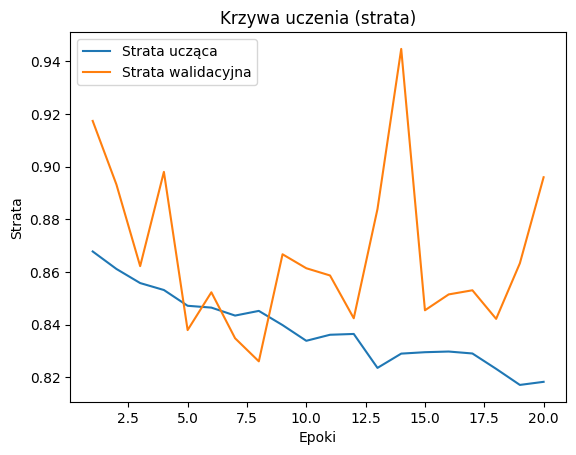

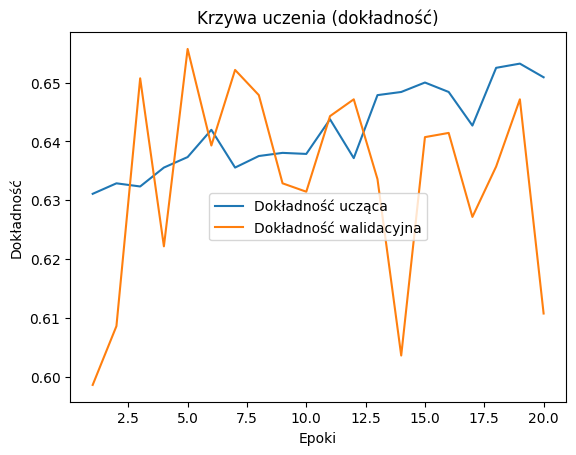

In [81]:
model.fit(train_inputs, train_classes_binary, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history = model.history.history
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Strata ucząca')
plt.plot(epochs, val_loss_values, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, label='Dokładność ucząca')
plt.plot(epochs, val_acc_values, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

In [82]:
# dane znormalizowane
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(7,)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(9, activation='softmax'))

model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_inputs2, train_classes_binary2, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 1s 1ms/step - loss: 1.5575 - accuracy: 0.3740
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 1.1715 - accuracy: 0.4997
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0875 - accuracy: 0.5191
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0502 - accuracy: 0.5379
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0353 - accuracy: 0.5410
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0231 - accuracy: 0.5451
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0144 - accuracy: 0.5464
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0083 - accuracy: 0.5523
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 1.0021 - accuracy: 0.5554
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.9952 - accuracy: 0.5611

In [83]:
test_loss2, test_acc2 = model2.evaluate(test_inputs2, test_classes_binary2, verbose = 0)
lista2.append(round(test_acc2, 2))
print('Dokładność: {:.2f}%'.format(test_acc2 * 100))
print(confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1)))

Dokładność: 56.40%
94/94 [==============================] - 0s 971us/step
[[319   0   0   0   0  31   0   2   5]
 [  0 355   0   0   0   0   0   0   0]
 [ 14   1 149   0  34  19   0  73  57]
 [  0   0   0 165   0   0 157   0   0]
 [ 10   0  54   0  50  19   0  93  93]
 [129   0   8   0  10  96   0  57  14]
 [  0   0   0  14   0   0 303   0   0]
 [ 22   0  45   0  28  41   0 124  57]
 [ 14   0  48   0  54  27   0  78 131]]


94/94 [==============================] - 0s 895us/step


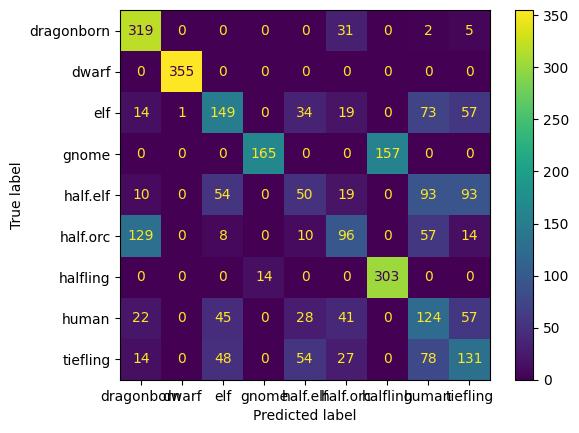

In [84]:
cm2 = confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9489 - accuracy: 0.5866 - val_loss: 0.9820 - val_accuracy: 0.5700
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9428 - accuracy: 0.5938 - val_loss: 1.0020 - val_accuracy: 0.5686
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9428 - accuracy: 0.5939 - val_loss: 0.9759 - val_accuracy: 0.5993
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9386 - accuracy: 0.5925 - val_loss: 0.9888 - val_accuracy: 0.5871
Epoch 5/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9368 - accuracy: 0.5996 - val_loss: 0.9759 - val_accuracy: 0.5921
Epoch 6/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9354 - accuracy: 0.6021 - val_loss: 0.9900 - val_accuracy: 0.5864
Epoch 7/20
175/175 [==============================] - 0s 2ms/step - loss: 0.9305 - accuracy: 0.5987 - val_loss: 0.9839 - val_accuracy: 0.5900
Epoch 

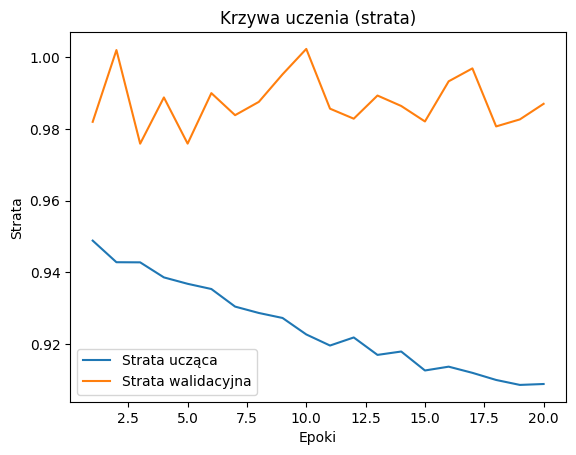

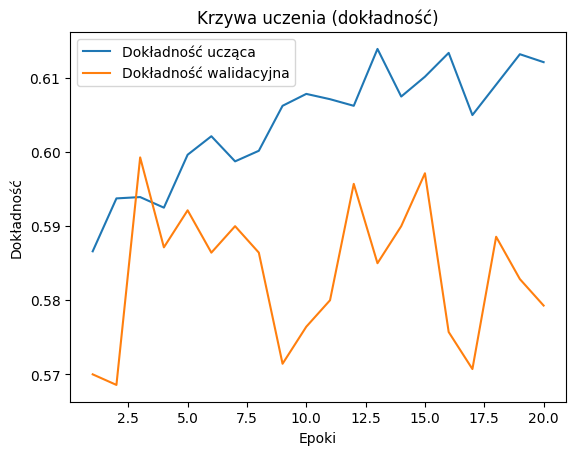

In [85]:
model2.fit(train_inputs2, train_classes_binary2, validation_split=0.2, shuffle=True, epochs=20, batch_size=32)
history2 = model2.history.history
loss_values2 = history2['loss']
val_loss_values2 = history2['val_loss']
acc_values2 = history2['accuracy']
val_acc_values2 = history2['val_accuracy']
epochs2 = range(1, len(loss_values2) + 1)

plt.plot(epochs2, loss_values2, label='Strata ucząca')
plt.plot(epochs2, val_loss_values2, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()
# jeśli wartość funkcji straty maleje na zbiorze treningowym, ale na zbiorze walidacyjnym jest stała (tutaj widzimy wahania,
# jednak pomarańczowa linia nie maleje, nie jest też do końca stała), to znaczy, że sieć jest za mało skomplikowana żeby
# dobrze nauczyć się danych

plt.plot(epochs2, acc_values2, label='Dokładność ucząca')
plt.plot(epochs2, val_acc_values2, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

### Sieć neuronowa (6) z większym rozmiarem batcha

In [86]:
# dane bez skalowania
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_inputs, train_classes_binary, epochs=20, batch_size=64)

Epoch 1/20
110/110 [==============================] - 1s 1ms/step - loss: 4.1488 - accuracy: 0.2786
Epoch 2/20
110/110 [==============================] - 0s 1ms/step - loss: 1.2897 - accuracy: 0.4911
Epoch 3/20
110/110 [==============================] - 0s 1ms/step - loss: 1.1863 - accuracy: 0.5173
Epoch 4/20
110/110 [==============================] - 0s 1ms/step - loss: 1.1147 - accuracy: 0.5557
Epoch 5/20
110/110 [==============================] - 0s 1ms/step - loss: 1.0664 - accuracy: 0.5791
Epoch 6/20
110/110 [==============================] - 0s 1ms/step - loss: 1.0078 - accuracy: 0.5963
Epoch 7/20
110/110 [==============================] - 0s 1ms/step - loss: 0.9851 - accuracy: 0.5973
Epoch 8/20
110/110 [==============================] - 0s 1ms/step - loss: 0.9729 - accuracy: 0.5969
Epoch 9/20
110/110 [==============================] - 0s 1ms/step - loss: 0.9607 - accuracy: 0.6013
Epoch 10/20
110/110 [==============================] - 0s 1ms/step - loss: 0.9400 - accuracy: 0.6100

In [87]:
test_loss, test_acc = model.evaluate(test_inputs, test_classes_binary, verbose = 0)
lista1.append(round(test_acc, 2))
print('Dokładność: {:.2f}%'.format(test_acc * 100))
print(confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1)))

Dokładność: 63.60%
94/94 [==============================] - 0s 917us/step
[[276   0   1   0   0  59   0  11  10]
 [  0 300   0   0   0  46   0   3   6]
 [  8   0 162   0   1  16   0  48 112]
 [  0   0   0 322   0   0   0   0   0]
 [  1   0  56   0   1  17   0  73 171]
 [ 42  12   6   0   0 203   0  31  20]
 [  0   0   0   0   0   0 317   0   0]
 [ 14   2  41   0   0  38   0 112 110]
 [  4   0  52   0   1  17   0  63 215]]


94/94 [==============================] - 0s 859us/step


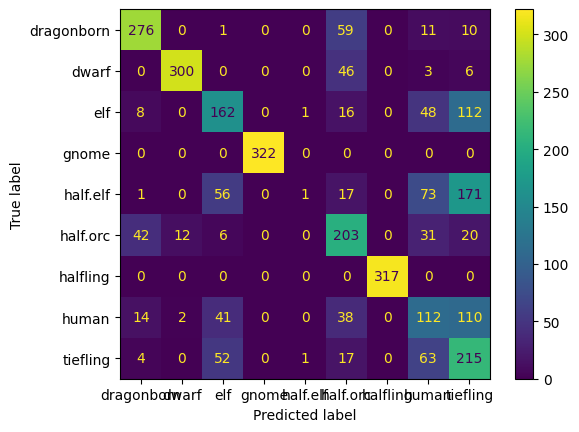

In [88]:
cm = confusion_matrix(test_classes_binary.numpy().argmax(axis=1), model.predict(test_inputs).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
88/88 [==============================] - 0s 2ms/step - loss: 0.8795 - accuracy: 0.6263 - val_loss: 0.8940 - val_accuracy: 0.6336
Epoch 2/20
88/88 [==============================] - 0s 2ms/step - loss: 0.8732 - accuracy: 0.6341 - val_loss: 0.9258 - val_accuracy: 0.6300
Epoch 3/20
88/88 [==============================] - 0s 2ms/step - loss: 0.8859 - accuracy: 0.6295 - val_loss: 0.9043 - val_accuracy: 0.5979
Epoch 4/20
88/88 [==============================] - 0s 2ms/step - loss: 0.8684 - accuracy: 0.6366 - val_loss: 0.9083 - val_accuracy: 0.6329
Epoch 5/20
88/88 [==============================] - 0s 2ms/step - loss: 0.8853 - accuracy: 0.6259 - val_loss: 0.9955 - val_accuracy: 0.6071
Epoch 6/20
88/88 [==============================] - 0s 2ms/step - loss: 0.8780 - accuracy: 0.6291 - val_loss: 0.8843 - val_accuracy: 0.6357
Epoch 7/20
88/88 [==============================] - 0s 2ms/step - loss: 0.8726 - accuracy: 0.6271 - val_loss: 0.8801 - val_accuracy: 0.6464
Epoch 8/20
88/88 [==

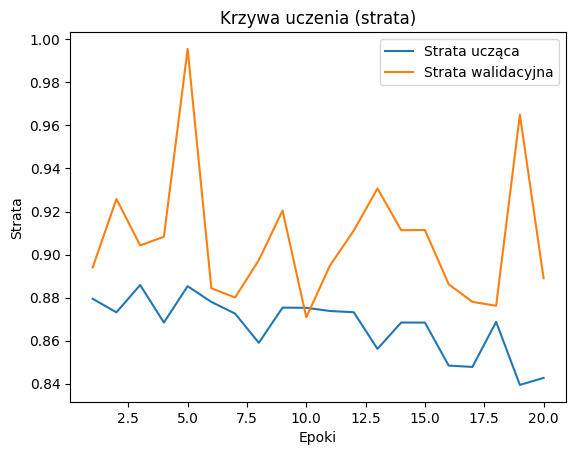

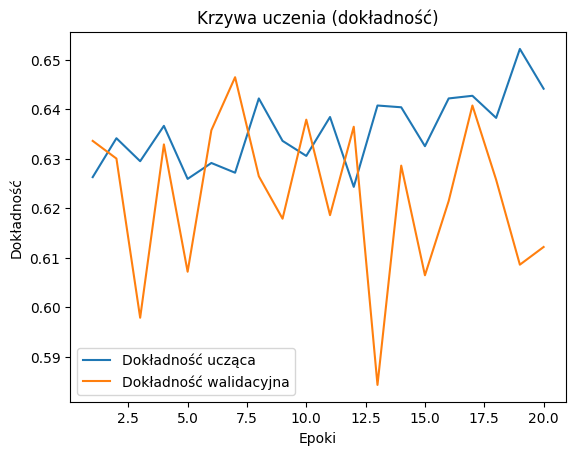

In [89]:
model.fit(train_inputs, train_classes_binary, validation_split=0.2, shuffle=True, epochs=20, batch_size=64)
history = model.history.history
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['accuracy']
val_acc_values = history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, label='Strata ucząca')
plt.plot(epochs, val_loss_values, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, label='Dokładność ucząca')
plt.plot(epochs, val_acc_values, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

In [90]:
# dane znormalizowane
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(7,)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(9, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(train_inputs2, train_classes_binary2, epochs=20, batch_size=64)

Epoch 1/20
110/110 [==============================] - 1s 1ms/step - loss: 1.7641 - accuracy: 0.3313
Epoch 2/20
110/110 [==============================] - 0s 1ms/step - loss: 1.2869 - accuracy: 0.4781
Epoch 3/20
110/110 [==============================] - 0s 2ms/step - loss: 1.1539 - accuracy: 0.5124
Epoch 4/20
110/110 [==============================] - 0s 2ms/step - loss: 1.0918 - accuracy: 0.5286
Epoch 5/20
110/110 [==============================] - 0s 2ms/step - loss: 1.0602 - accuracy: 0.5367
Epoch 6/20
110/110 [==============================] - 0s 2ms/step - loss: 1.0415 - accuracy: 0.5376
Epoch 7/20
110/110 [==============================] - 0s 2ms/step - loss: 1.0310 - accuracy: 0.5401
Epoch 8/20
110/110 [==============================] - 0s 2ms/step - loss: 1.0198 - accuracy: 0.5476
Epoch 9/20
110/110 [==============================] - 0s 1ms/step - loss: 1.0155 - accuracy: 0.5449
Epoch 10/20
110/110 [==============================] - 0s 1ms/step - loss: 1.0089 - accuracy: 0.5511

In [91]:
test_loss2, test_acc2 = model2.evaluate(test_inputs2, test_classes_binary2, verbose = 0)
lista2.append(round(test_acc2, 2))
print('Dokładność: {:.2f}%'.format(test_acc2 * 100))
print(confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1)))

Dokładność: 57.07%
94/94 [==============================] - 0s 832us/step
[[282   0   0   0   1  65   0   5   4]
 [  0 355   0   0   0   0   0   0   0]
 [  6   0 186   0  36  27   0  62  30]
 [  0   0   0 277   0   0  45   0   0]
 [  4   0  79   0  69  27   0  93  47]
 [ 98   0  18   0  15 128   0  50   5]
 [  0   0   0  93   0   0 224   0   0]
 [ 12   0  58   0  37  54   0 115  41]
 [  9   0  81   0  81  31   0  74  76]]


94/94 [==============================] - 0s 2ms/step


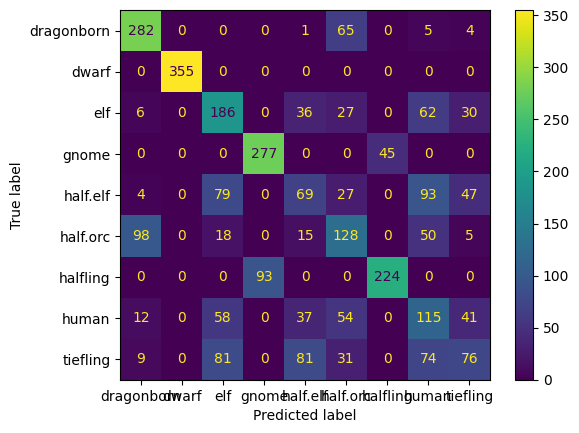

In [92]:
cm2 = confusion_matrix(test_classes_binary2.numpy().argmax(axis=1), model2.predict(test_inputs2).argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['dragonborn', 'dwarf', 'elf',
                                                                              'gnome', 'half.elf', 'half.orc',
                                                                              'halfling', 'human', 'tiefling'])
cm_display.plot()
plt.show()

Epoch 1/20
88/88 [==============================] - 0s 2ms/step - loss: 0.9626 - accuracy: 0.5832 - val_loss: 0.9929 - val_accuracy: 0.5721
Epoch 2/20
88/88 [==============================] - 0s 2ms/step - loss: 0.9563 - accuracy: 0.5877 - val_loss: 0.9848 - val_accuracy: 0.5936
Epoch 3/20
88/88 [==============================] - 0s 2ms/step - loss: 0.9547 - accuracy: 0.5934 - val_loss: 0.9909 - val_accuracy: 0.5764
Epoch 4/20
88/88 [==============================] - 0s 2ms/step - loss: 0.9504 - accuracy: 0.5896 - val_loss: 0.9908 - val_accuracy: 0.5693
Epoch 5/20
88/88 [==============================] - 0s 2ms/step - loss: 0.9468 - accuracy: 0.5923 - val_loss: 0.9908 - val_accuracy: 0.5807
Epoch 6/20
88/88 [==============================] - 0s 2ms/step - loss: 0.9467 - accuracy: 0.5902 - val_loss: 0.9906 - val_accuracy: 0.5807
Epoch 7/20
88/88 [==============================] - 0s 3ms/step - loss: 0.9430 - accuracy: 0.6004 - val_loss: 0.9797 - val_accuracy: 0.5950
Epoch 8/20
88/88 [==

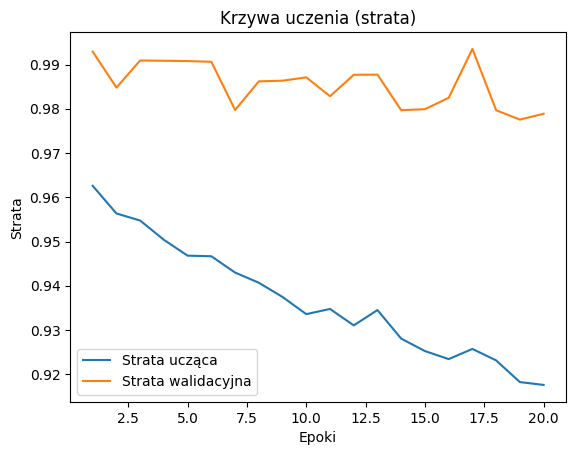

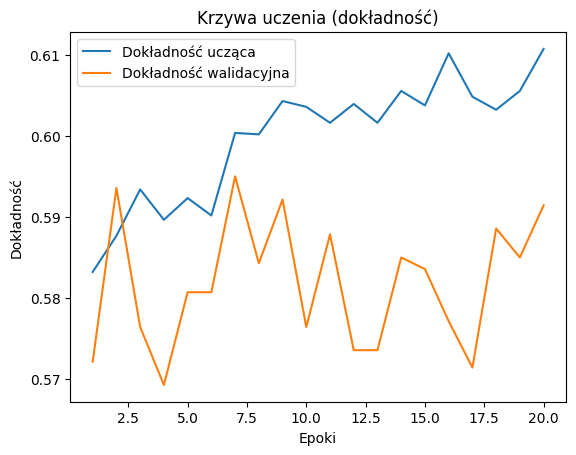

In [93]:
model2.fit(train_inputs2, train_classes_binary2, validation_split=0.2, shuffle=True, epochs=20, batch_size=64)
history2 = model2.history.history
loss_values2 = history2['loss']
val_loss_values2 = history2['val_loss']
acc_values2 = history2['accuracy']
val_acc_values2 = history2['val_accuracy']
epochs2 = range(1, len(loss_values2) + 1)

plt.plot(epochs2, loss_values2, label='Strata ucząca')
plt.plot(epochs2, val_loss_values2, label='Strata walidacyjna')
plt.title('Krzywa uczenia (strata)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

plt.plot(epochs2, acc_values2, label='Dokładność ucząca')
plt.plot(epochs2, val_acc_values2, label='Dokładność walidacyjna')
plt.title('Krzywa uczenia (dokładność)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

## 4. Podsumowanie

Porównać klasyfikatory dla obu wersji bazy danych. Który zadziałał najlepiej?

In [95]:
# indeksy w tabeli:
# DD i DD2 - drzewa decyzyjne,
# NB - naiwny Bayes,
# NNk - k-najbliższych sąsiadów dla k = 3, 5, 11,
# Neunet - sieć neuronowa
tabela = pd.DataFrame(data=
                      {'Dane nieprzetworzone': lista1,
                       'Dane przetworzone': lista2},
                      index=['DD', 'DD2', 'NB', 'NN3', 'NN5', 'NN11',
                             'Neunet', 'Neunet2', 'Neunet3', 'Neunet4', 'Neunet5', 'Neunet6'])
tabela
# Dobre klasyfikatory osiągają z reguły bardzo wysokie (min. 90%) dokładności.
# Żaden z klasyfikatorów nie radzi sobie dobrze z klasyfikacją dziewięciu klas postaci z gry DnD.
# Jednak dla danych bez obróbki najwyższą dokładność osiągnęło drzewo decyzyjne z przyciętymi gałęziami,
# natomiast w przypadku danych po normalizacji i pca najwyższą dokładność ma sieć neuronowa z większą liczbą epok.
# Możemy też zauważyć, że klasyfikatory lepiej radziły sobie z danymi przed przetworzeniem (różnica w dokładności
# może wynosić ponad 20%).

Dane nieprzetworzone  Dane przetworzone
DD                       0.69               0.49
DD2                      0.69               0.49
NB                       0.61               0.54
NN3                      0.61               0.45
NN5                      0.62               0.48
NN11                     0.62               0.49
Neunet                   0.63               0.56
Neunet2                  0.56               0.56
Neunet3                  0.64               0.57
Neunet4                  0.66               0.58
Neunet5                  0.64               0.56
Neunet6                  0.64               0.57

## Bibliografia

Baza danych:
- https://www.kaggle.com/datasets/andrewabeles/dnd-stats

Optymalizacja drzewa decyzyjnego:
- https://analizadanychwpilce.com/2019/10/11/optymalizacja-drzewa-decyzyjnego/